In [1]:
import sqlite3
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from collections import Counter
from os.path import join

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

#PCA
from sklearn.decomposition import PCA

#Hierarchical Clustering
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

#KMeans Clustering
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans

#Density Clustering
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MeanShift, DBSCAN, estimate_bandwidth

#MiniSOM
!pip install minisom
from minisom import MiniSom

##Matplotlib functions to create MiniSOM visualizations
from matplotlib.patches import RegularPolygon, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colorbar
from matplotlib import colors as mpl_colors
from matplotlib.lines import Line2D

from sklearn.base import clone
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import dendrogram
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split

from matplotlib import __version__ as mplver
print("matplotlib version is:" , mplver)

import math
from math import ceil

import warnings
warnings.filterwarnings('ignore')

%config InlineBackend.figure_format = 'retina'

sns.set()

matplotlib version is: 3.9.1


In [2]:
df = pd.read_csv('data_clean.csv')

In [3]:
df.columns

Index(['Unnamed: 0', 'customer_region_0', 'customer_region_1',
       'customer_region_2', 'customer_region_3', 'vendor_count',
       'product_count', 'is_chain', 'last_promo', 'payment_method',
       'CUI_American', 'CUI_Asian', 'CUI_Beverages', 'CUI_Cafe',
       'CUI_Chicken_Dishes', 'CUI_Chinese', 'CUI_Desserts', 'CUI_Healthy',
       'CUI_Indian', 'CUI_Italian', 'CUI_Japanese', 'CUI_Noodle_Dishes',
       'CUI_OTHER', 'CUI_Street_Food/Snacks', 'CUI_Thai', 'DOW_0', 'DOW_1',
       'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6', 'Total_Orders_Per_Client',
       'mnt', 'mnt_Per_Order', 'Items_Per_Order', 'frq', 'rcn', 'activity',
       'Loyalty', 'Age_Group', 'CLV_Score', 'Orders_Night', 'Orders_Dawn',
       'Orders_Morning', 'Orders_Afternoon', 'Orders_Evening', 'Orders_Dusk',
       'RFM_Score'],
      dtype='object')

In [4]:
metric_features = df.select_dtypes(include=np.number).set_index(df.index).columns.tolist()
non_metric_features = df.columns[df.columns.str.startswith(('customer_', 'last_', 'payment_','Peak_'))].tolist()
print('non metric:',non_metric_features)
# Exclude non_metric_features from metric_features
metric_features = list(set(metric_features) - set(non_metric_features))
print('metric:',metric_features)

non metric: ['customer_region_0', 'customer_region_1', 'customer_region_2', 'customer_region_3', 'last_promo', 'payment_method']
metric: ['RFM_Score', 'DOW_2', 'CUI_Cafe', 'Unnamed: 0', 'activity', 'vendor_count', 'is_chain', 'product_count', 'CUI_American', 'Orders_Morning', 'frq', 'rcn', 'CUI_Indian', 'CUI_Healthy', 'CUI_Beverages', 'DOW_5', 'CUI_Noodle_Dishes', 'Loyalty', 'CUI_Desserts', 'Orders_Evening', 'DOW_4', 'DOW_3', 'CUI_Chicken_Dishes', 'CLV_Score', 'CUI_Thai', 'DOW_6', 'CUI_OTHER', 'mnt_Per_Order', 'Items_Per_Order', 'Orders_Dawn', 'Orders_Afternoon', 'CUI_Japanese', 'CUI_Italian', 'Age_Group', 'CUI_Asian', 'Total_Orders_Per_Client', 'Orders_Dusk', 'DOW_0', 'CUI_Chinese', 'DOW_1', 'Orders_Night', 'CUI_Street_Food/Snacks', 'mnt']


In [5]:
value_engagement_metrics = [
    # Value
    'mnt', 'mnt_Per_Order', 'CLV_Score', 'RFM_Score',
    # Engagement
    'activity', 'Loyalty', 'frq', 'rcn' , 'Age_Group']

preference_metrics = [
    # Cuisine preferences
    'CUI_American', 'CUI_Asian', 'CUI_Beverages', 'CUI_Cafe',
    'CUI_Chicken_Dishes', 'CUI_Chinese', 'CUI_Desserts', 'CUI_Healthy',
    'CUI_Indian', 'CUI_Italian', 'CUI_Japanese', 'CUI_Noodle_Dishes',
    'CUI_OTHER', 'CUI_Street_Food/Snacks', 'CUI_Thai'
]

shopping_behavior_metrics = [
    # Shopping patterns
    'vendor_count', 'product_count', 'is_chain', 'Items_Per_Order',
    # Timing preferences
    'Orders_Night', 'Orders_Dawn', 'Orders_Morning', 'Orders_Afternoon',
    'Orders_Evening', 'Orders_Dusk',
    'DOW_0', 'DOW_1', 'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6'
]

demographic_metrics = [
    'customer_region_0', 'customer_region_1', 'customer_region_2',
    'customer_region_3'
]

"""Loyalty
        Age_Group, i dropped these from value
"""

'Loyalty\n        Age_Group, i dropped these from value\n'

## Functions

#### PCA

In [6]:
def _color_red_or_green(val):
    if val < -0.45:
        color = 'background-color: #ffbdbd'
    elif val > 0.45:
        color = 'background-color: #b3ffcc'
    else:
        color = ''
    return color

#### SOM

In [7]:
#component planes
def plot_component_planes(som,
                          figsize=(20,20),
                          features=None,
                          figrows=3,
                          title="SOM Visualization",
                          cmap=cm.coolwarm
                         ):

    xx, yy = som.get_euclidean_coordinates()
    weights = som.get_weights()
    

    fig = plt.figure(figsize=figsize, constrained_layout=True)
    subfigs = fig.subfigures(figrows, 
                         int(np.ceil(len(features)/figrows)))
    


    for cpi, sf in zip(range(len(value_columns)), subfigs.flatten()):
        
        colornorm = mpl_colors.Normalize(vmin=np.min(weights[:, cpi % len(weights[0])]), 
                                 vmax=np.max(weights[:, cpi % len(weights[0])]))

        axs = sf.subplots(1,1)
        axs.set_aspect('equal')
        axs.set_title(features[cpi], y=0.95)

        for i in range(weights.shape[0]):
            for j in range(weights.shape[1]):
                wy = yy[(i, j)] * np.sqrt(3) / 2
                hexagon = RegularPolygon((xx[(i, j)], wy), 
                                     numVertices=6, 
                                     radius=.99 / np.sqrt(3),
                                     facecolor=cmap(colornorm(weights[i, j, cpi])), 
                                     alpha=1, 
                                     edgecolor=cmap(colornorm(weights[i, j, cpi]))
                                    )
                axs.add_patch(hexagon)

        ## Remove axes for hex plot
        axs.margins(.05)
        axs.axis("off")

        ## Add colorbar
        divider = make_axes_locatable(axs)

        ax_cb = divider.append_axes("right", size="7%")

        ## Create a Mappable object
        cmap_sm = plt.cm.ScalarMappable(cmap=cmap, norm=colornorm)
        cmap_sm.set_array([])

        ## Create custom colorbar 
        cb1 = colorbar.Colorbar(ax_cb,
                                orientation='vertical', 
                                alpha=1,
                                mappable=cmap_sm
                                )
        cb1.ax.get_yaxis().labelpad = 6

        ## Add colorbar to plot
        sf.add_axes(ax_cb)

    fig.suptitle(title, fontsize='xx-large', y=1.05)
    plt.show()

In [8]:
# U-matrix and Hit map
def plot_som_hexagons(som,
                      matrix,
                      cmap=cm.Blues,
                      figsize=(20,20),
                      annotate=True,
                      title="SOM Matrix",
                      cbar_label="Color Scale"
                ):

    xx, yy = som.get_euclidean_coordinates()

    f = plt.figure(figsize=figsize)
    ax = f.add_subplot(111)

    ax.set_aspect('equal')
    ax.set_title(title, fontsize=20)

    colornorm = mpl_colors.Normalize(vmin=np.min(matrix), 
                                     vmax=np.max(matrix))

    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            wy = yy[(i, j)] * np.sqrt(3) / 2
            hexagon = RegularPolygon((xx[(i, j)], wy), 
                                 numVertices=6, 
                                 radius=.95 / np.sqrt(3),
                                 facecolor=cmap(colornorm(matrix[i, j])), 
                                 alpha=1)
            ax.add_patch(hexagon)

            if annotate:
                annot_vals = np.round(matrix[i, j],2)
                if annot_vals > 1:
                    annot_vals = int(annot_vals)
                
                ax.text(xx[(i, j)], wy, annot_vals, 
                        ha='center', va='center', 
                        fontsize=15, 
                        )

    ax.margins(.05)
    ax.axis("off")

    ## Create a Mappable object
    cmap_sm = plt.cm.ScalarMappable(cmap=cmap, norm=colornorm)
    cmap_sm.set_array([])
    
    divider = make_axes_locatable(plt.gca())
    ax_cb = divider.new_horizontal(size="2%", pad=0)    
    cb1 = colorbar.ColorbarBase(ax_cb, 
                                orientation='vertical', 
                                alpha=1,
                                mappable=cmap_sm
                               )
    cb1.ax.get_yaxis().labelpad = 16
    cb1.ax.set_ylabel(cbar_label, fontsize=18)
    plt.gcf().add_axes(ax_cb)

    return plt

#### Hierarchical Clustering

In [9]:
def get_ss(df, feats):
    """
    Calculate the sum of squares (SS) for the given DataFrame.
    The sum of squares is computed as the sum of the variances of each column
    multiplied by the number of non-NA/null observations minus one.
    Parameters:
    df (pandas.DataFrame): The input DataFrame for which the sum of squares is to be calculated.
    feats (list of str): A list of feature column names to be used in the calculation
    Returns:
    float: The sum of squares of the DataFrame.
    """
    df_ = df[feats]
    ss = np.sum(df_.var() * (df_.count() - 1))
    return ss 

def get_ssb(df, feats, label_col):
    """
    Calculate the between-group sum of squares (SSB) for the given DataFrame.
    The between-group sum of squares is computed as the sum of the squared differences
    between the mean of each group and the overall mean, weighted by the number of observations
    in each group.
    Parameters:
    df (pandas.DataFrame): The input DataFrame containing the data.
    feats (list of str): A list of feature column names to be used in the calculation.
    label_col (str): The name of the column in the DataFrame that contains the group labels.
    Returns
    float: The between-group sum of squares of the DataFrame.
    """
    ssb_i = 0
    for i in np.unique(df[label_col]):
        df_ = df.loc[:, feats]
        X_ = df_.values
        X_k = df_.loc[df[label_col] == i].values
        
        ssb_i += (X_k.shape[0] * (np.square(X_k.mean(axis=0) - X_.mean(axis=0))) )

    ssb = np.sum(ssb_i)
    return ssb

def get_ssw(df, feats, label_col):
    """
    Calculate the sum of squared within-cluster distances (SSW) for a given DataFrame.
    Parameters:
    df (pandas.DataFrame): The input DataFrame containing the data.
    feats (list of str): A list of feature column names to be used in the calculation.
    label_col (str): The name of the column containing cluster labels.
    Returns:
    float: The sum of squared within-cluster distances (SSW).
    """
    feats_label = feats+[label_col]
    df_k = df[feats_label].groupby(by=label_col).apply(lambda col: get_ss(col, feats))
    return df_k.sum()

In [10]:
def get_rsq(df, feats, label_col):
    """
    Calculate the R-squared value for a given DataFrame and features.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing the data.
    feats (list): A list of feature column names to be used in the calculation.
    label_col (str): The name of the column containing the labels or cluster assignments.

    Returns:
    float: The R-squared value, representing the proportion of variance explained by the clustering.
    """

    df_sst_ = get_ss(df, feats)                 # get total sum of squares
    df_ssw_ = get_ssw(df, feats, label_col)     # get ss within
    df_ssb_ = df_sst_ - df_ssw_                 # get ss between

    # r2 = ssb/sst 
    return (df_ssb_/df_sst_)

def get_r2_hc(df, link_method, max_nclus, min_nclus=1, dist="euclidean"):
    """This function computes the R2 for a set of cluster solutions given by the application of a hierarchical method.
    The R2 is a measure of the homogenity of a cluster solution. It is based on SSt = SSw + SSb and R2 = SSb/SSt. 
    
    Parameters:
    df (DataFrame): Dataset to apply clustering
    link_method (str): either "ward", "complete", "average", "single"
    max_nclus (int): maximum number of clusters to compare the methods
    min_nclus (int): minimum number of clusters to compare the methods. Defaults to 1.
    dist (str): distance to use to compute the clustering solution. Must be a valid distance. Defaults to "euclidean".
    
    Returns:
    ndarray: R2 values for the range of cluster solutions
    """
    
    r2 = []  # where we will store the R2 metrics for each cluster solution
    feats = df.columns.tolist()
    
    for i in range(min_nclus, max_nclus+1):  # iterate over desired ncluster range
        cluster = AgglomerativeClustering(n_clusters=i, metric=dist, linkage=link_method)
        
        #get cluster labels
        hclabels = cluster.fit_predict(df) 
        
        # concat df with labels
        df_concat = pd.concat([df, pd.Series(hclabels, name='labels', index=df.index)], axis=1)  
        
        
        # append the R2 of the given cluster solution
        r2.append(get_rsq(df_concat, feats, 'labels'))
        
    return np.array(r2)

## Value and Engagement Based

In [11]:
# Get original column names from df
val_clean = df[value_engagement_metrics].copy()

# Clip extremely large values to prevent overflow
max_value = 1e15  # Set a reasonable maximum value
val_clean = val_clean.clip(upper=max_value)

# Handle potential zero or negative values
val_clean['mnt'] = np.maximum(val_clean['mnt'], 0.01)
val_clean['activity'] = np.maximum(val_clean['activity'], 0)
val_clean['frq'] = np.maximum(val_clean['frq'], 0)
val_clean['rcn'] = np.maximum(val_clean['rcn'], 0)

# Apply log transformation safely
val_clean['CLV_Score'] = np.log1p(val_clean['CLV_Score'])

# Calculate features with safeguards against division by zero and overflow
val_clean['value_retention'] = np.log1p(val_clean['mnt']) / np.maximum(val_clean['activity'] + 1, 0.01)
val_clean['value_growth'] = val_clean['mnt'] / (np.maximum(val_clean['rcn'] + 1, 0.01) * np.maximum(val_clean['frq'] + 1, 0.01))
val_clean['value_growth_rate'] = val_clean['value_growth'] * np.log1p(val_clean['frq'])
val_clean['growth_momentum'] = val_clean['value_growth'] * (val_clean['mnt'] / np.maximum(val_clean['rcn'], 0.01))

val_clean['spend_consistency'] = val_clean['mnt'] / np.maximum(val_clean['rcn'] + 1, 0.01)
val_clean['avg_order_value'] = val_clean['mnt'] / np.maximum(val_clean['frq'] + 1, 0.01)
val_clean['active_spend_rate'] = np.log1p(val_clean['mnt'] * val_clean['activity']) / np.maximum(np.log1p(val_clean['rcn']), 0.01)

final_cols = ['CLV_Score', 'value_retention', 'value_growth', 'value_growth_rate',
                'growth_momentum', 'spend_consistency', 'avg_order_value', 'active_spend_rate']

# Replace infinite values with NaN and then fill with mean
val_clean[final_cols] = val_clean[final_cols].replace([np.inf, -np.inf], np.nan)
val_clean[final_cols] = val_clean[final_cols].fillna(val_clean[final_cols].mean())

# Scale the features
val_clean[final_cols] = StandardScaler().fit_transform(val_clean[final_cols])
val_clean

mnt  mnt_Per_Order  CLV_Score  RFM_Score  activity  Loyalty  \
0      0.306394       0.578417   0.742053       0.55  0.011111      0.0   
1      0.202472       0.379445   0.689780       0.45  0.011111      0.0   
2      0.094895       0.173895   0.635179       0.35  0.011111      0.6   
3      0.335196       0.633505   0.086328       0.55  0.022222      0.0   
4      0.591832       1.000000   0.228171       0.65  0.022222      0.0   
...         ...            ...        ...        ...       ...      ...   
31732  0.189898       0.726413   2.586655       0.80  0.000000      0.0   
31733  0.189898       0.726413   2.586655       0.80  0.000000      0.0   
31734  0.187211       0.716136   2.586655       0.80  0.000000      0.0   
31735  0.125309       0.479342   2.586655       0.70  0.000000      0.0   
31736  0.081032       0.309969   2.586655       0.70  0.000000      0.0   

            frq       rcn  Age_Group  value_retention  value_growth  \
0      0.717691  1.000000        0.2         0.587148     -0.712116   
1      0.717691  1.000000        0.0        -0.107159     -0.835650   
2      0.717691  1.000000        0.6        -0.892170     -0.963529   
3      0.473024  0.988889        0.4         0.743488     -0.609100   
4      0.473024  0.988889        0.2         2.200059     -0.251373   
...         ...       ...        ...              ...           ...   
31732  0.717691  0.000000        0.4        -0.179025     -0.624862   
31733  0.717691  0.000000        0.4        -0.179025     -0.624862   
31734  0.717691  0.000000        0.2        -0.198169     -0.631249   
31735  0.717691  0.000000        0.4        -0.651686     -0.778418   
31736  0.717691  0.000000        0.4        -0.991653     -0.883684   

       value_growth_rate  growth_momentum  spend_consistency  avg_order_value  \
0               0.572915        -0.400294          -0.540315        -0.501915   
1               0.090905        -0.402728          -0.736031        -0.729350   
2              -0.408052        -0.404200          -0.938627        -0.964782   
3               0.457031        -0.398483          -0.482547        -0.317035   
4               1.456348        -0.385500           0.003471         0.337905   
...                  ...              ...                ...              ...   
31732           0.913363        -0.072693          -0.402080        -0.756868   
31733           0.913363        -0.072693          -0.402080        -0.756868   
31734           0.888440        -0.082019          -0.412200        -0.762748   
31735           0.314215        -0.260084          -0.645358        -0.898222   
31736          -0.096515        -0.344177          -0.812131        -0.995123   

       active_spend_rate  
0              -0.482013  
1              -0.482338  
2              -0.482676  
3              -0.480858  
4              -0.479249  
...                  ...  
31732          -0.482974  
31733          -0.482974  
31734          -0.482974  
31735          -0.482974  
31736          -0.482974  

[31737 rows x 16 columns]

#### PCA

In [12]:
df_pca = val_clean
df_pca.shape

(31737, 16)

In [13]:
pca = PCA()
pca_feat = pca.fit_transform(df_pca)

In [14]:
# Get PCA output as table

# Get the eigenvalues (explained variance)
explained_variance = pca.explained_variance_

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# get the cumulative explained variance ratio 
# Hint: use np.cumsum()
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

# Combine into a dataframe
pca_results = pd.DataFrame(
    {
        "Eigenvalue": explained_variance,
        "Difference": np.insert(np.diff(explained_variance), 0, 0),
        "Proportion": explained_variance_ratio,
        "Cumulative": cumulative_explained_variance_ratio
    },
        index=range(1, pca.n_components_ + 1)
)

pca_results

Eigenvalue  Difference  Proportion  Cumulative
1     5.614962    0.000000    0.657237    0.657237
2     1.337073   -4.277889    0.156506    0.813743
3     0.922483   -0.414590    0.107978    0.921720
4     0.278963   -0.643521    0.032653    0.954373
5     0.157427   -0.121536    0.018427    0.972800
6     0.061471   -0.095955    0.007195    0.979995
7     0.053459   -0.008012    0.006257    0.986253
8     0.043445   -0.010014    0.005085    0.991338
9     0.025034   -0.018410    0.002930    0.994268
10    0.020548   -0.004487    0.002405    0.996673
11    0.013058   -0.007490    0.001528    0.998202
12    0.007052   -0.006005    0.000825    0.999027
13    0.004982   -0.002070    0.000583    0.999610
14    0.003244   -0.001738    0.000380    0.999990
15    0.000060   -0.003184    0.000007    0.999997
16    0.000025   -0.000035    0.000003    1.000000

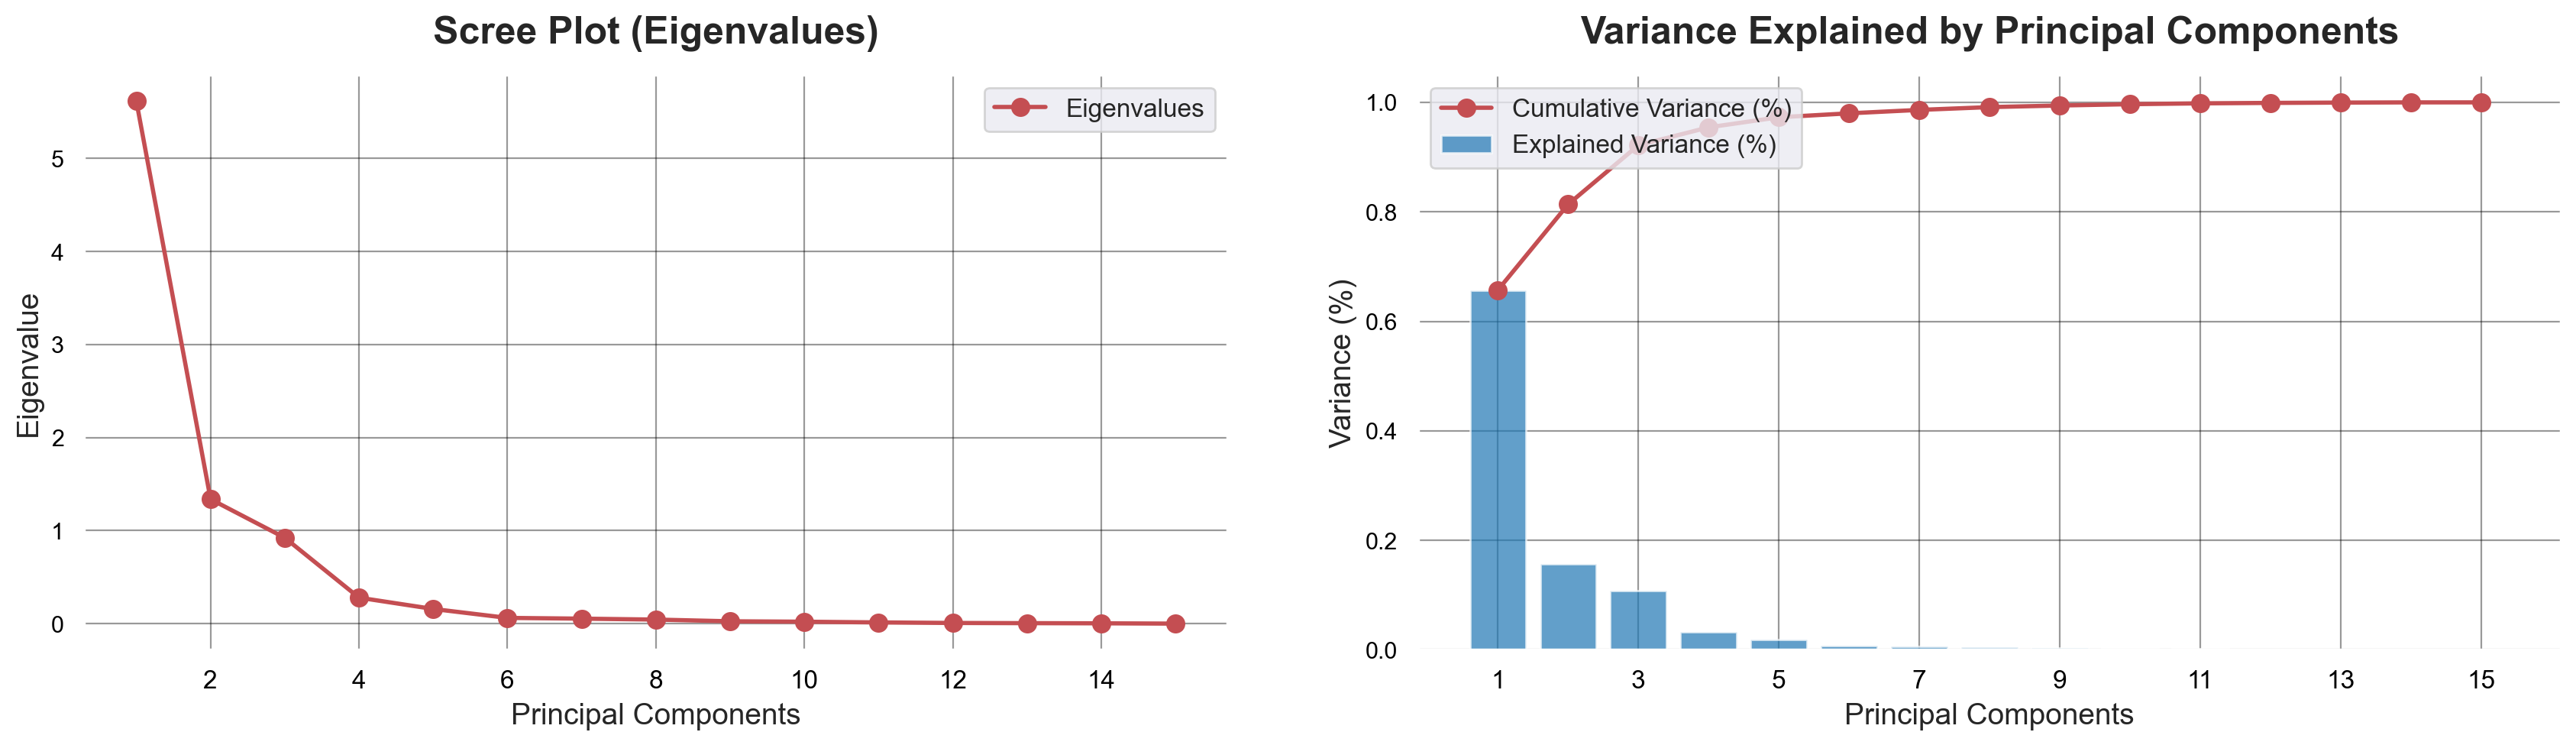

In [15]:
n_pcas = 15

# Create figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), facecolor='white')

# Plot 1: Scree Plot (Eigenvalues)
ax1.plot(range(1, n_pcas + 1), explained_variance[:n_pcas], 'ro-', linewidth=2, markersize=8, label='Eigenvalues')
ax1.set_title("Scree Plot (Eigenvalues)", fontsize=18, pad=15, fontweight='bold')
ax1.set_xlabel("Principal Components", fontsize=14)
ax1.set_ylabel("Eigenvalue", fontsize=14)
ax1.set_xticks(range(2, n_pcas + 1, 2))
ax1.set_xticklabels(range(2, n_pcas + 1, 2), fontsize=12)
ax1.set_facecolor('white')
ax1.grid(True, color='black', linestyle='-', linewidth=0.8, alpha=0.4)  # Lighter grid lines
ax1.tick_params(axis='both', which='both', colors='black', width=1)  # Black ticks with better visibility
ax1.legend(fontsize=12, loc='upper right')

# Plot 2: Explained Variance as a Bar Chart (up to 30 PCs)
ax2.bar(range(1, n_pcas + 1), explained_variance_ratio[:n_pcas], 
        color='#1f77b4', alpha=0.7, label='Explained Variance (%)', width=0.8)  # Customize bar color
ax2.plot(range(1, n_pcas + 1), cumulative_explained_variance_ratio[:n_pcas], 
         'ro-', linewidth=2, markersize=8, label='Cumulative Variance (%)')

# Customize the plot
ax2.set_title("Variance Explained by Principal Components", fontsize=18, pad=15, fontweight='bold')
ax2.set_xlabel("Principal Components", fontsize=14)
ax2.set_ylabel("Variance (%)", fontsize=14)
ax2.set_xticks(range(1, n_pcas + 1, 2))  # Show every 2nd PC for clarity
ax2.set_xticklabels(range(1, n_pcas + 1, 2), fontsize=12)
ax2.set_facecolor('white')
ax2.grid(True, color='black', linestyle='-', linewidth=0.8, alpha=0.4)  # Lighter grid lines
ax2.tick_params(axis='both', which='both', colors='black', width=1)  # Black ticks with better visibility

# Add legend
ax2.legend(fontsize=12, loc='upper left')

# Adjust layout to ensure everything fits and has proper padding
plt.tight_layout(pad=4.0)

# Show plot
plt.show()


 Cumulative percentage of total variance
* keep 80% of total variance
 Kaiser's rule
* keep PC var >=1
 Scree plot
* elbow method

In [16]:
# we decided to retain 2 PCAs as its an Elbow and allows us to retain around 80% of variance as well as around 1 PC variance
pca = PCA(n_components=2)
pca_feat = pca.fit_transform(df_pca)
pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]

# remember index=df_pca.index
pca_df = pd.DataFrame(pca_feat, index=df_pca.index, columns=pca_feat_names)  

In [17]:
df_pca_final = pd.concat([df_pca, pca_df], axis=1)
correlation_matrix = df_pca_final[pca_feat_names + df_pca.columns.tolist()].corr()
loadings = correlation_matrix.loc[pca_feat_names, df_pca.columns]

loadings.style.applymap(_color_red_or_green)

we can drop total order per client, activity, mnt per order and item per order

In [18]:
df_pca_final.drop(['mnt', 'CLV_Score', 'value_retention', 'value_growth', 'spend_consistency', 'avg_order_value'], axis = 1, inplace = True)
df_value = df_pca_final.copy()
value_columns = df_value.columns.tolist()

features that can be exchanged by one of the pcas:
PCA0:
- product count
- total orders per client

### SOM

In [19]:
M = 10
N = 10

# Get the number of features in the data
num_features = df_value.shape[1]

# Create a SOM with 10x10 map size
sm = MiniSom(M, N, num_features, 
             learning_rate=0.01, 
             activation_distance='euclidean',
             topology='hexagonal', 
             neighborhood_function='bubble', 
             random_seed=42)

# Initialize the weights of the SOM randomly
sm.random_weights_init(df_value.values)

# Calculate the quantization error before training
qe_before = np.round(sm.quantization_error(df_value.values), 4)
print(f"Quantization error before training: {qe_before}")

# Train the SOM using all the vectors in data sequentially
sm.train_batch(df_value.values, 100000)

# Calculate the quantization error after training
qe_after = np.round(sm.quantization_error(df_value.values), 4)
print(f"Quantization error after training: {qe_after}")

Quantization error before training: 0.657
Quantization error after training: 0.5438


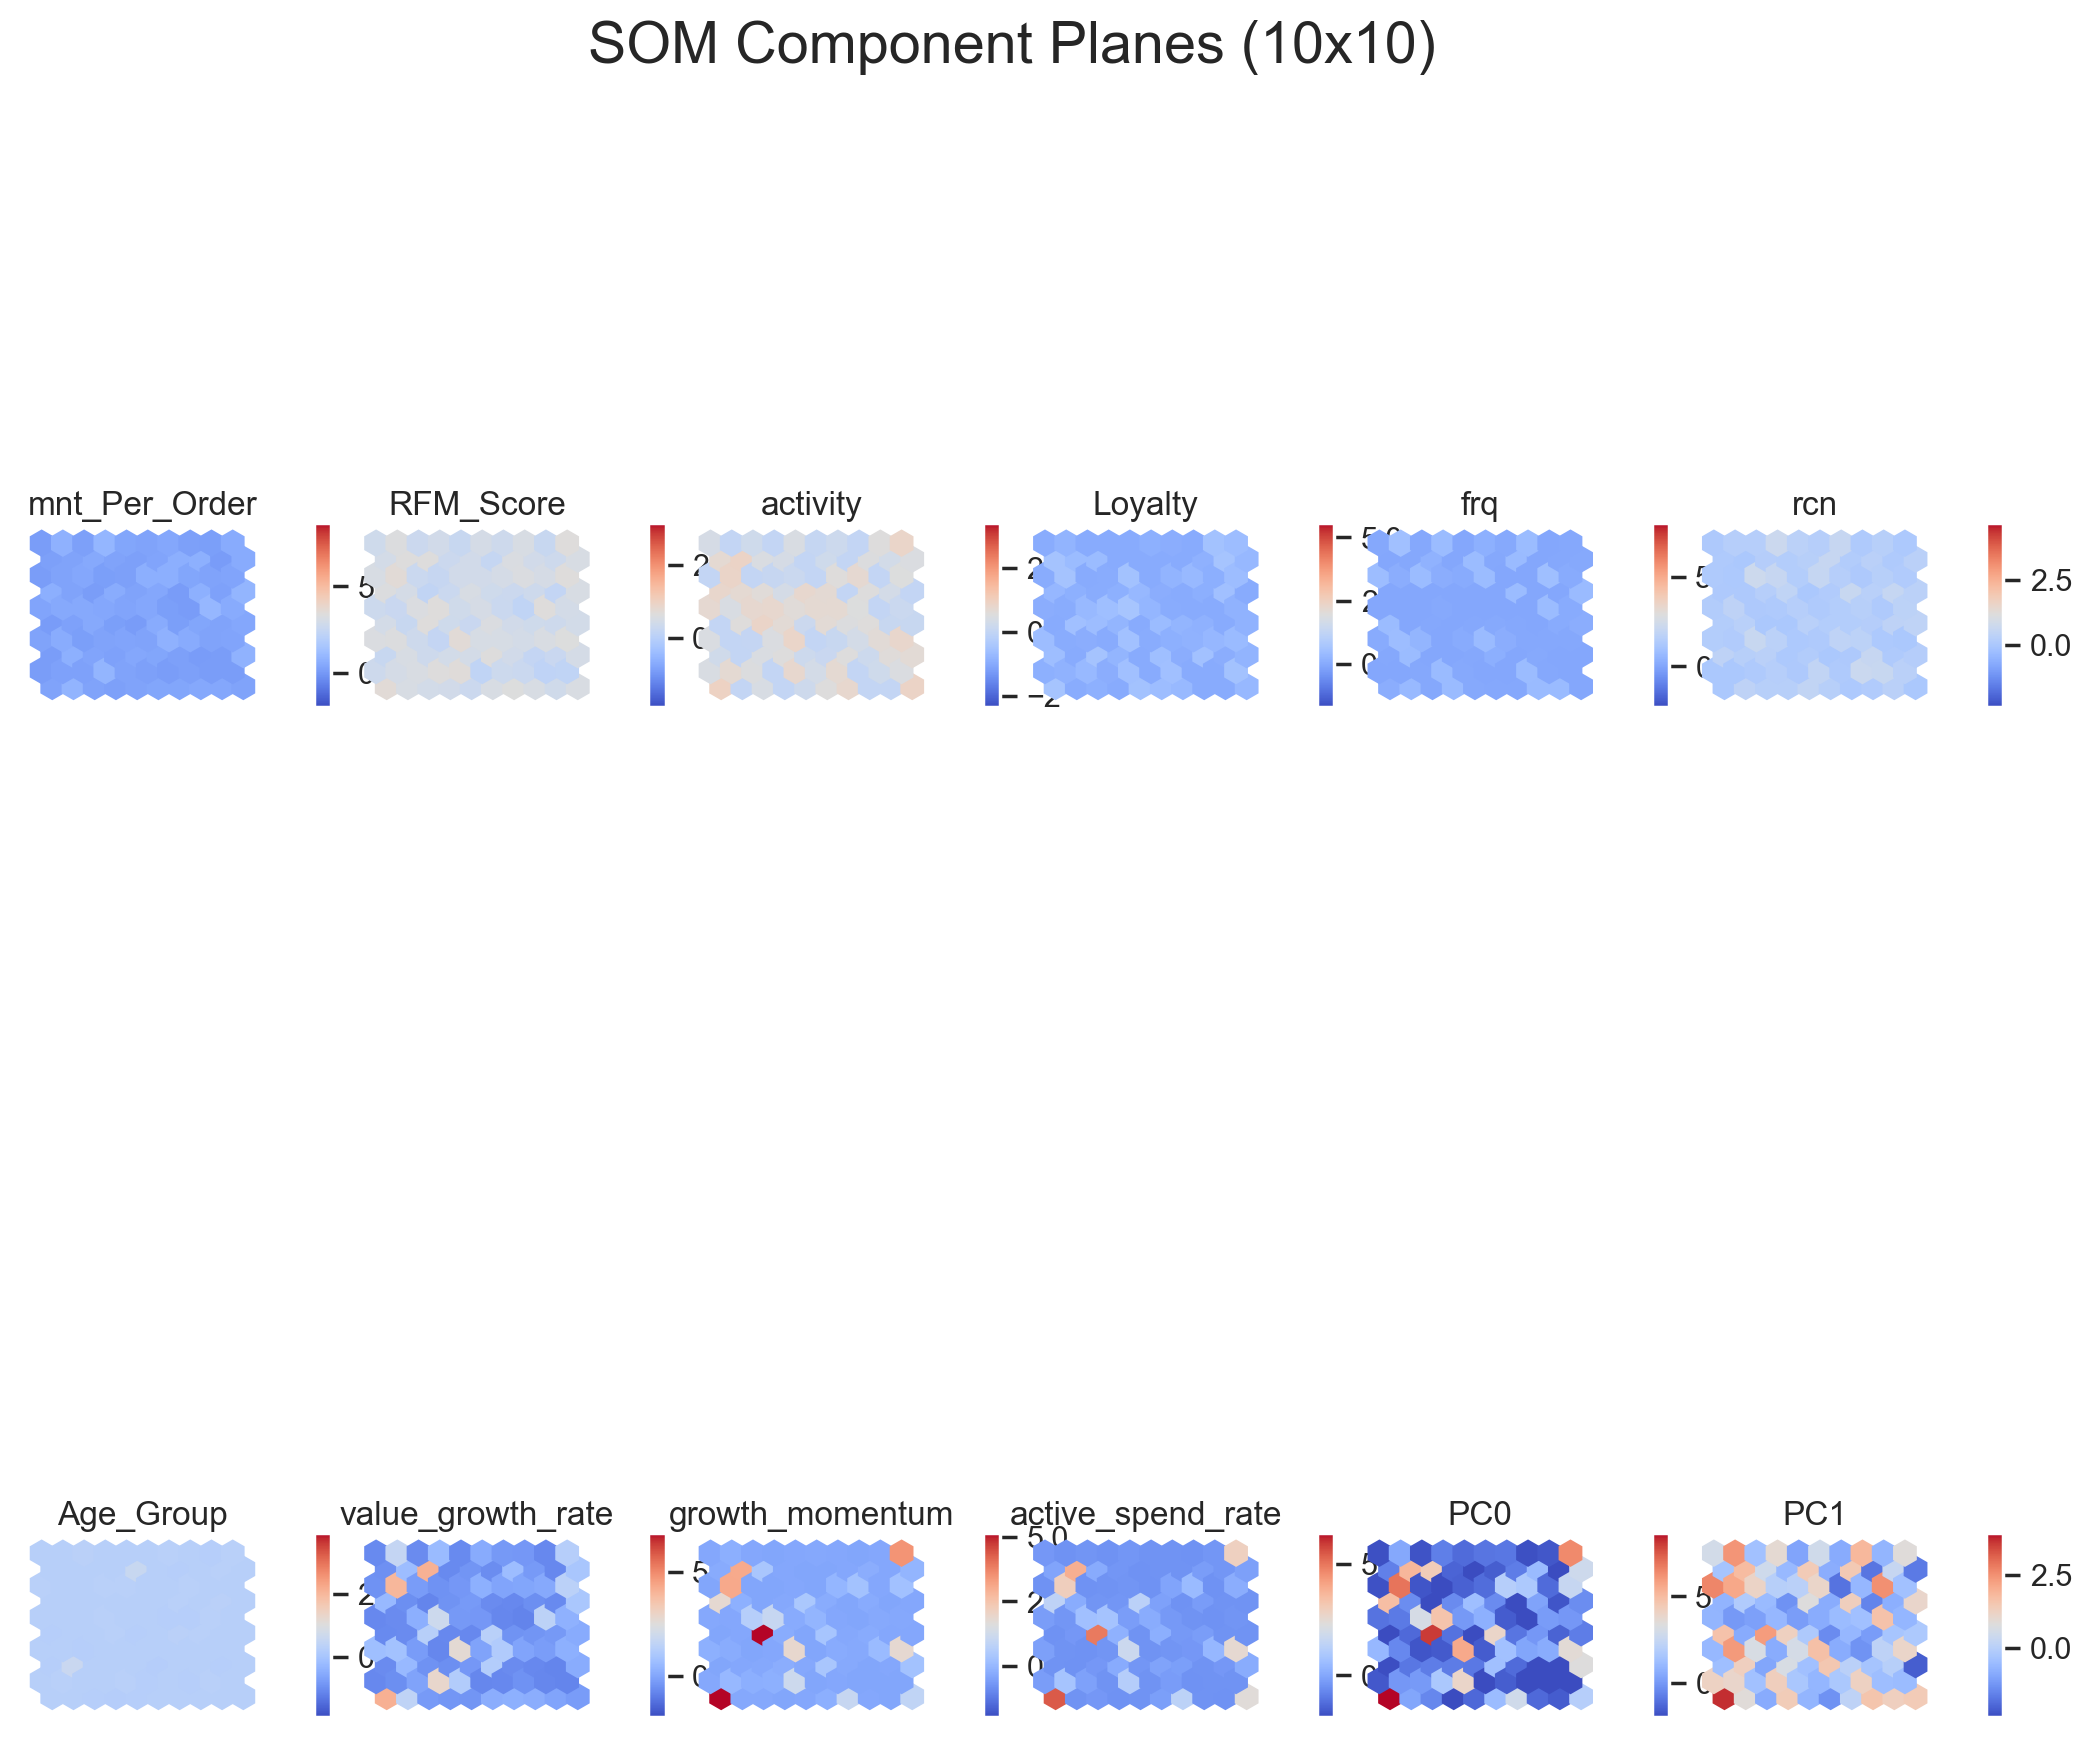

In [20]:
## Plot Component Planes
plot_component_planes(sm,
                      features=value_columns,
                      figsize=(10,10),
                      figrows=2,
                      title="SOM Component Planes ({}x{})".format(M,N)
                     )

#### U-matrix and Hit-map

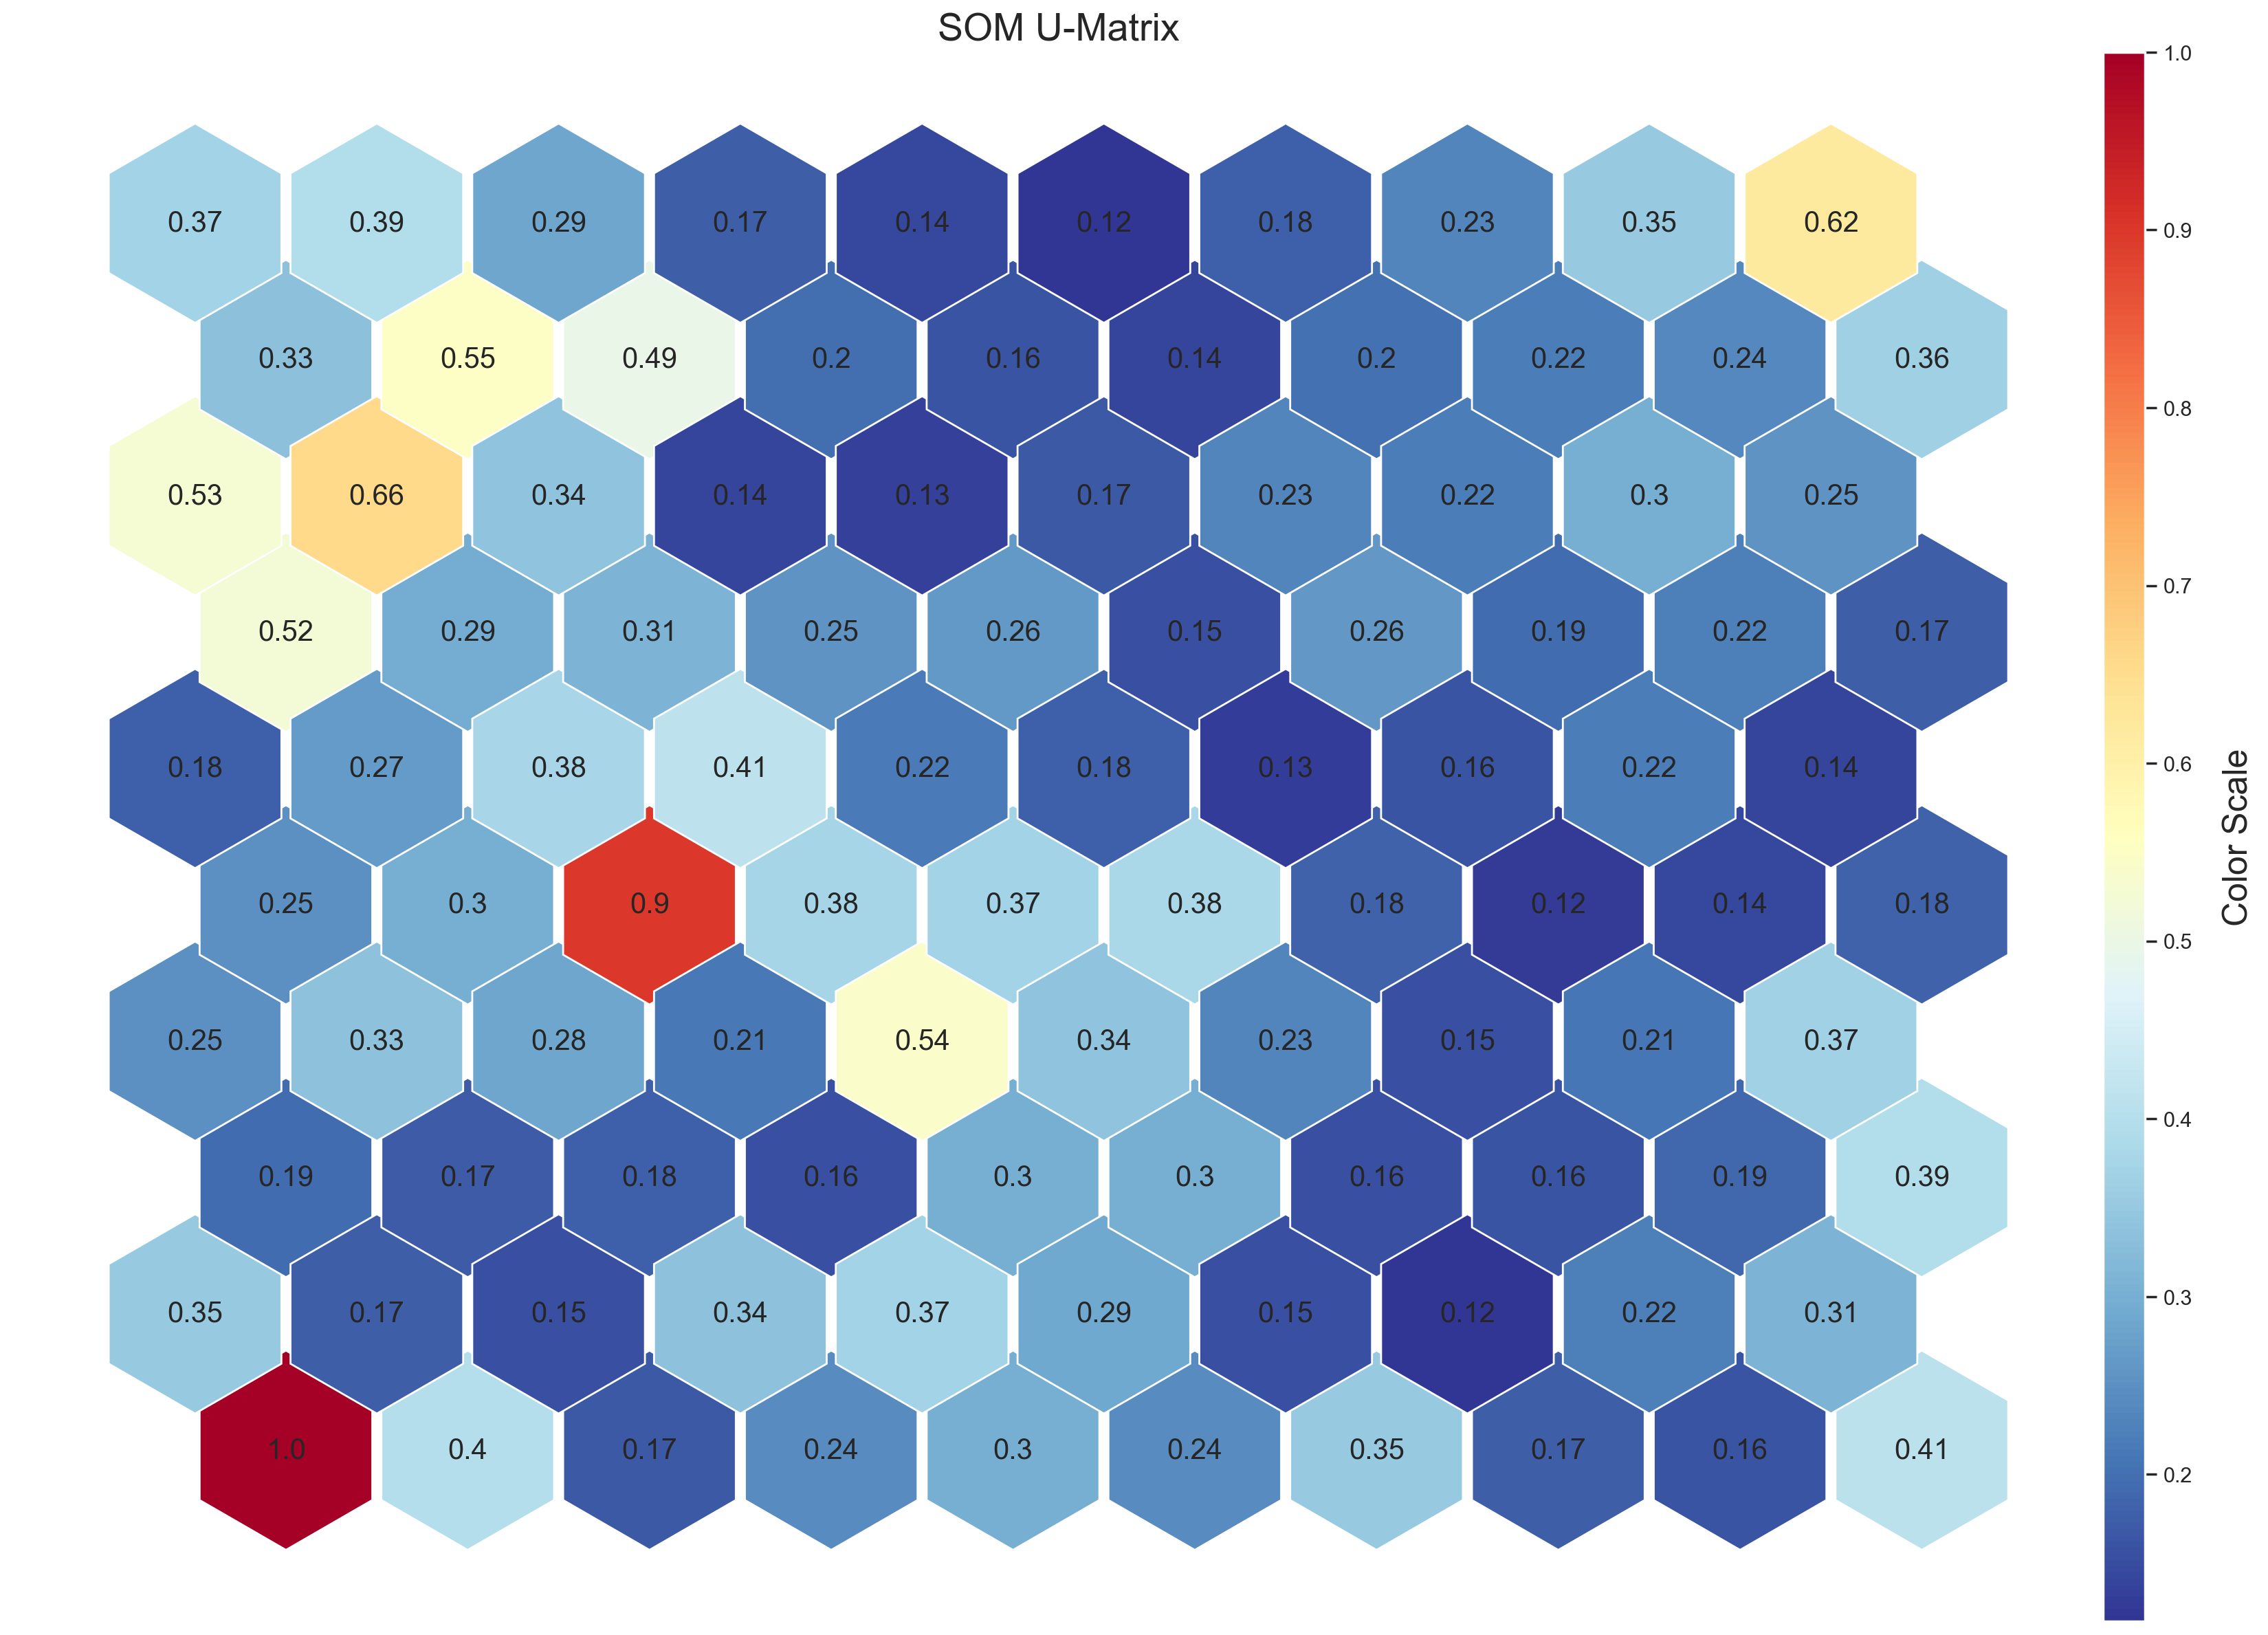

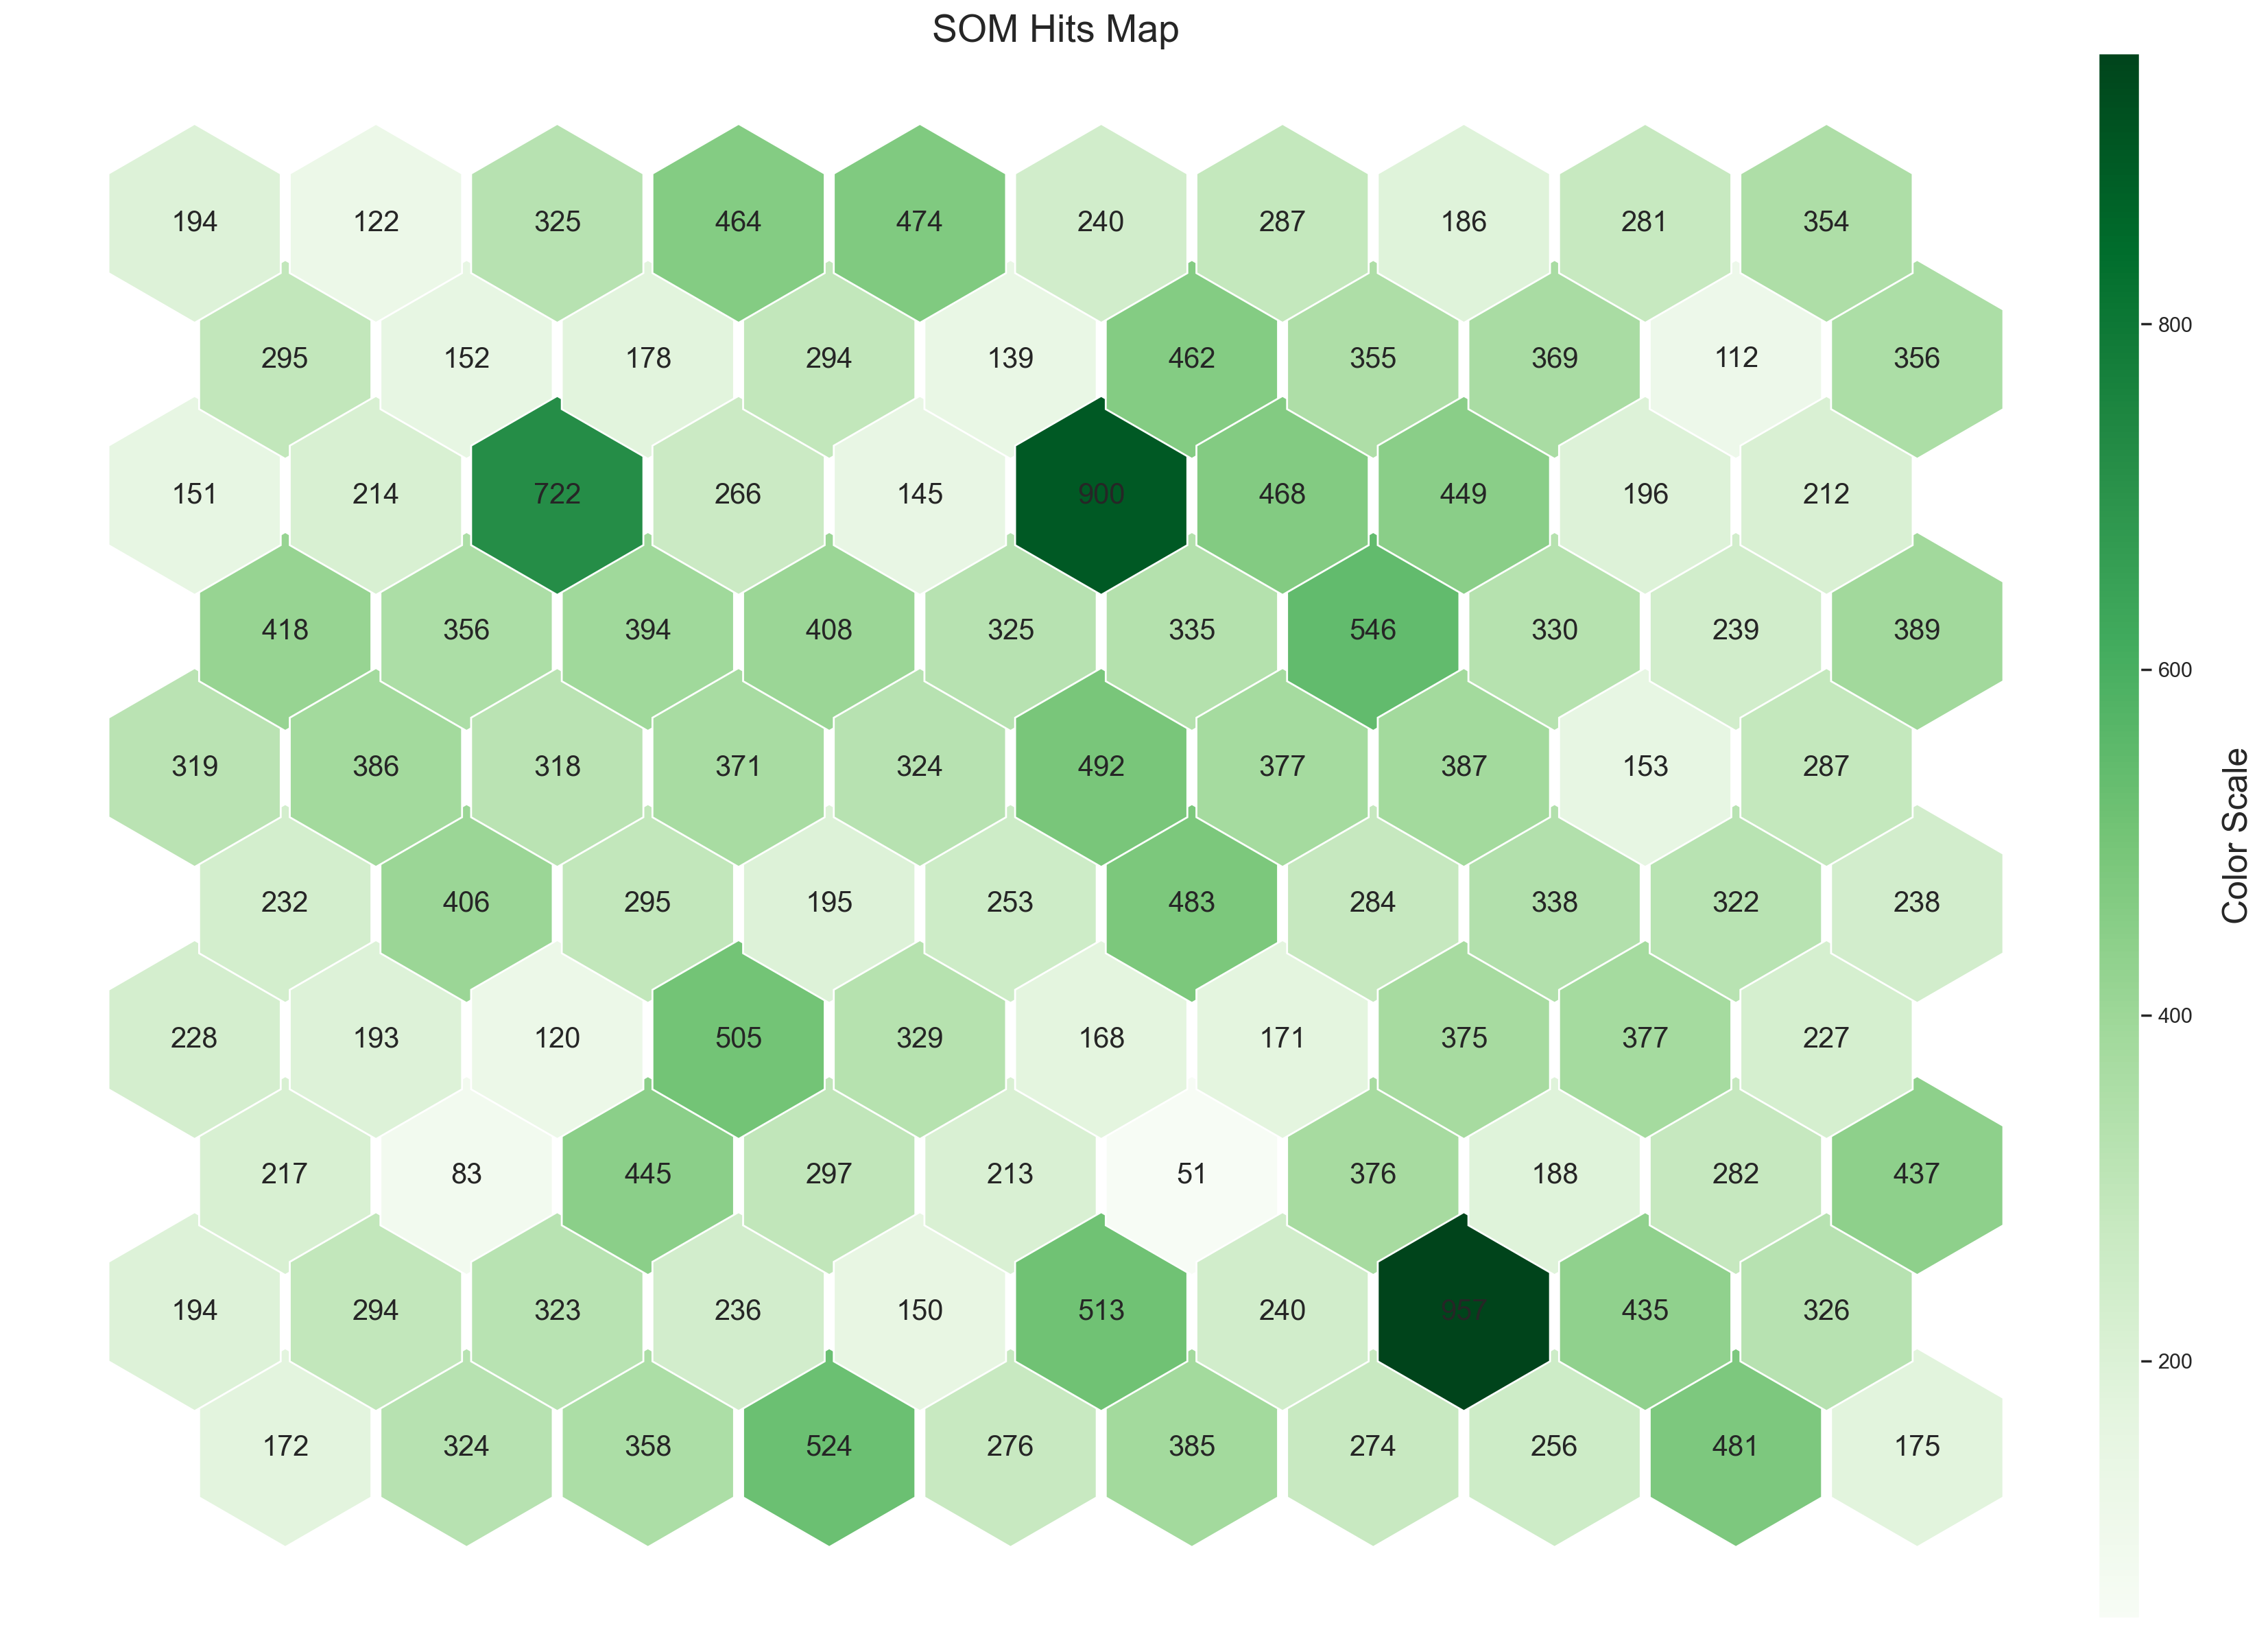

In [21]:
umatrix = sm.distance_map(scaling='mean')

fig = plot_som_hexagons(sm, umatrix, cmap=cm.RdYlBu_r, title="SOM U-Matrix")
plt.show()

hitsmatrix = sm.activation_response(df_value.values)

fig = plot_som_hexagons(sm, hitsmatrix, cmap=cm.Greens, title="SOM Hits Map")
plt.show()

In [22]:
weights = sm.get_weights().reshape((M*N),df_value.shape[1])
weights.shape

(100, 12)

## Clustering

### Hierarchical Clustering

try SOM with full dataset before Hierarchical and use the units resulting from SOM in Hierarchical to decide clusters

In [23]:
# Performing HC
hclust = AgglomerativeClustering(linkage='ward', metric='euclidean', n_clusters=5)
hc_labels = hclust.fit_predict(df_value)

In [24]:
# Characterizing the clusters
labels_series = pd.Series(hc_labels, 
                          name='labels', 
                          index=df.index 
                          ) 

df_concat = pd.concat(
    [df_value, labels_series],
    axis=1)

df_concat[value_columns+['labels']].groupby('labels').mean()

mnt_Per_Order  RFM_Score  activity   Loyalty       frq       rcn  \
labels                                                                     
0            0.446384   0.559207  0.493825  0.238040  0.134337  0.212959   
1            0.513346   0.723613  0.696582  0.356998  0.090056  0.136366   
2            0.415059   0.853032  0.858079  0.508020  0.157301  0.029133   
3            0.428918   0.490520  0.005395  0.018609  0.696028  0.492338   
4            0.233900   0.300944  0.392644  0.168179  0.067004  0.349409   

        Age_Group  value_growth_rate  growth_momentum  active_spend_rate  \
labels                                                                     
0        0.354365          -0.020530        -0.187456          -0.045443   
1        0.357465           0.828357         0.752076           0.721548   
2        0.358119           2.428093         4.256201           3.921267   
3        0.352593          -0.046685        -0.393309          -0.480774   
4        0.353725          -0.651942        -0.387676          -0.409401   

             PC0       PC1  
labels                      
0       0.218991 -0.368662  
1       3.469904 -0.821514  
2       7.263111  2.089102  
3      -1.480233  1.299661  
4      -1.664323 -0.502805

In [25]:
df_sst_ = get_ss(df_concat, value_columns)
df_ssb_ = get_ssb(df_concat, value_columns, 'labels')
df_ssw_ = get_ssw(df_concat, value_columns, 'labels')

print("SSb:  ", df_ssb_)
print("SSw:  ", df_ssw_)
print("SSt:  ", df_sst_)
print("SSt == SSb+SSw ? ", np.isclose(df_sst_, df_ssb_ + df_ssw_, atol=1))

SSb:   248783.12519644058
SSw:   81671.55834041147
SSt:   330454.68353684555
SSt == SSb+SSw ?  True


In [26]:
'''hc_methods = ["ward" ,"complete", "average", "single"]
max_nclus = 10

r2_hc = np.vstack([ get_r2_hc(df_value, 
                              link, 
                              max_nclus=max_nclus, 
                              min_nclus=1, 
                              dist="euclidean") 
                              for link in hc_methods])

r2_hc_methods = pd.DataFrame(r2_hc.T, index=range(1, max_nclus + 1), columns=hc_methods)

sns.set()

# Plot data
fig = plt.figure(figsize=(11,5))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

# Finalize the plot
plt.legend(title="HC methods", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)

fig.suptitle("$R^2$ plot for various hierarchical methods", fontsize=21)

plt.show()'''

'hc_methods = ["ward" ,"complete", "average", "single"]\nmax_nclus = 10\n\nr2_hc = np.vstack([ get_r2_hc(df_value, \n                              link, \n                              max_nclus=max_nclus, \n                              min_nclus=1, \n                              dist="euclidean") \n                              for link in hc_methods])\n\nr2_hc_methods = pd.DataFrame(r2_hc.T, index=range(1, max_nclus + 1), columns=hc_methods)\n\nsns.set()\n\n# Plot data\nfig = plt.figure(figsize=(11,5))\nsns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)\n\n# Finalize the plot\nplt.legend(title="HC methods", title_fontsize=11)\nplt.xticks(range(1, max_nclus + 1))\nplt.xlabel("Number of clusters", fontsize=13)\nplt.ylabel("R2 metric", fontsize=13)\n\nfig.suptitle("$R^2$ plot for various hierarchical methods", fontsize=21)\n\nplt.show()'

#### Defining Number of Clusters

In [27]:
# setting distance_threshold=0 and n_clusters=None ensures we compute the full tree
linkage = 'ward'
distance = 'euclidean'

hclust = AgglomerativeClustering(linkage=linkage, metric=distance, distance_threshold=0, n_clusters=None)
hclust.fit_predict(df_value)

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

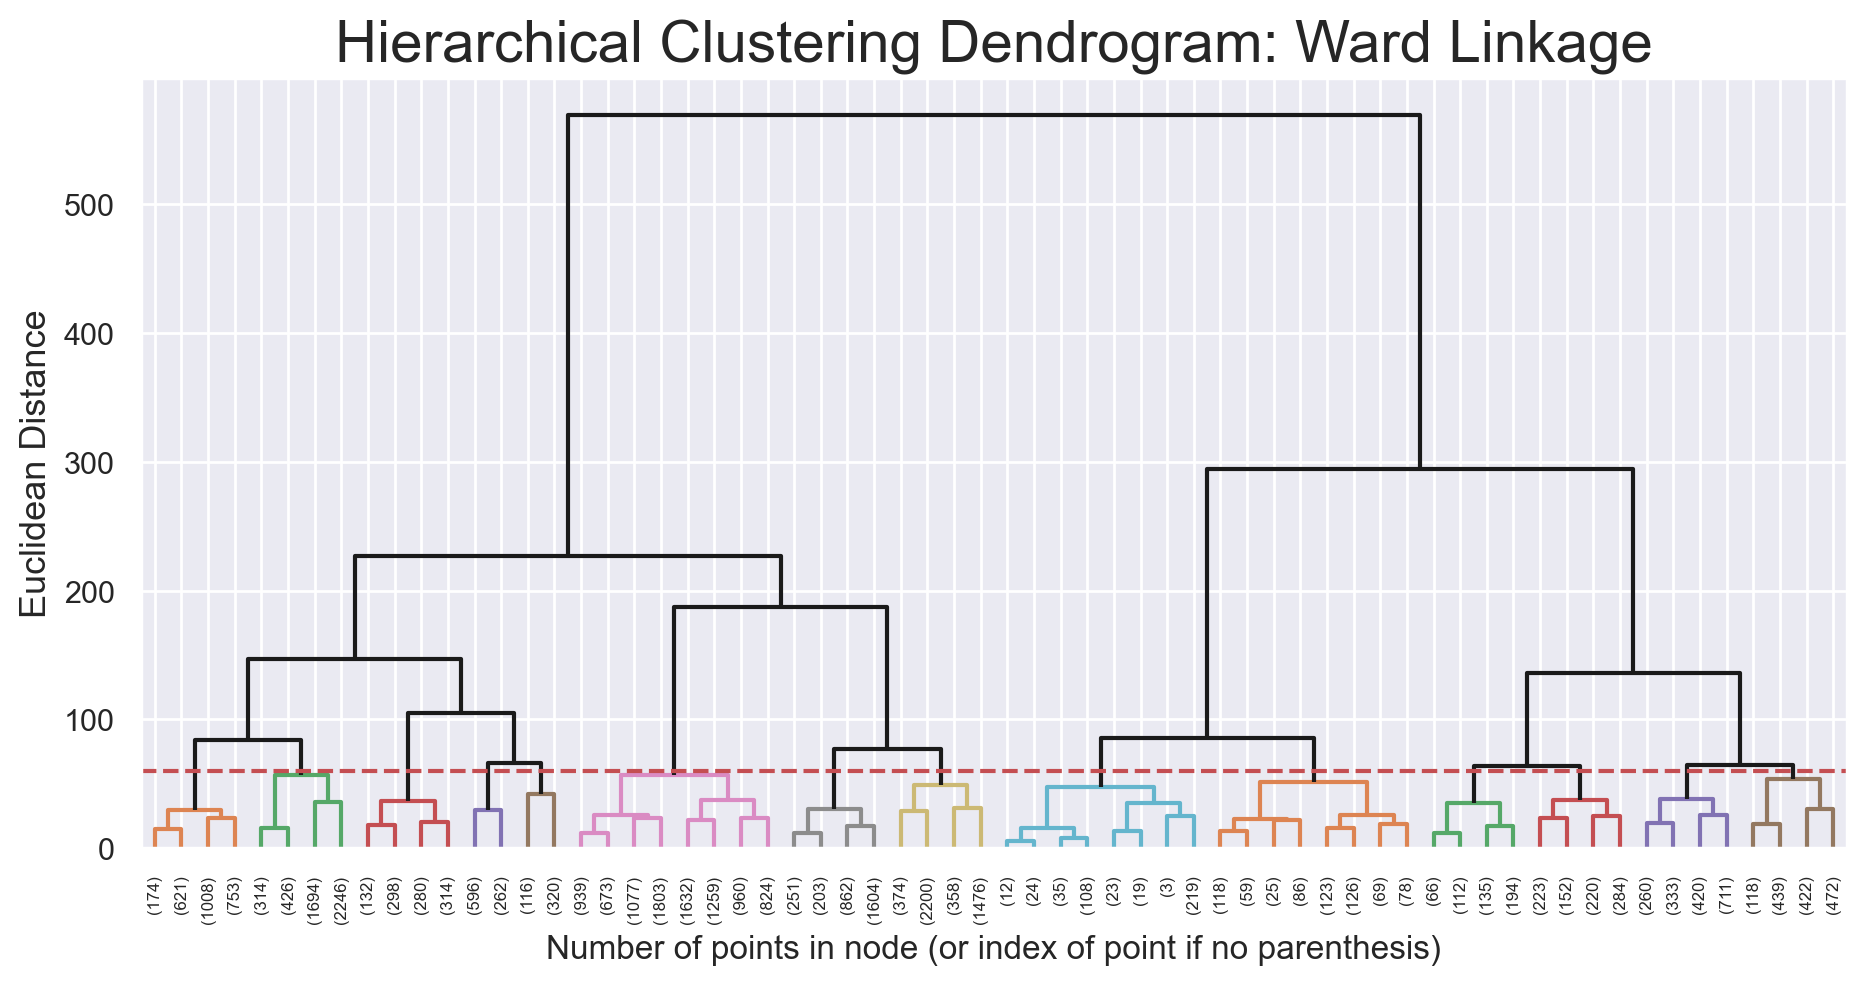

In [28]:
# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 200
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering Dendrogram: {linkage.title()} Linkage', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

#### Testing cluster solutions

In [30]:
# final cluster solution
linkage = "ward"
distance = "euclidean"
n_clusters = 4

hclust = AgglomerativeClustering(linkage=linkage, metric=distance, n_clusters=n_clusters)

hc_labels = hclust.fit_predict(df_value)

# Characterizing the final clusters

df_concat = pd.concat([
    df_value, 
    pd.Series(hc_labels, name='labels', index=df.index)
    ], 
    axis=1)
df_concat.groupby('labels').mean()

mnt_Per_Order  RFM_Score  activity   Loyalty       frq       rcn  \
labels                                                                     
0            0.366695   0.448998  0.320815  0.151725  0.268654  0.339572   
1            0.513346   0.723613  0.696582  0.356998  0.090056  0.136366   
2            0.415059   0.853032  0.858079  0.508020  0.157301  0.029133   

        Age_Group  value_growth_rate  growth_momentum  active_spend_rate  \
labels                                                                     
0        0.353641          -0.250090        -0.315826          -0.295990   
1        0.357465           0.828357         0.752076           0.721548   
2        0.358119           2.428093         4.256201           3.921267   

             PC0       PC1  
labels                      
0      -0.921792  0.053457  
1       3.469904 -0.821514  
2       7.263111  2.089102

#### Cluster Visualization

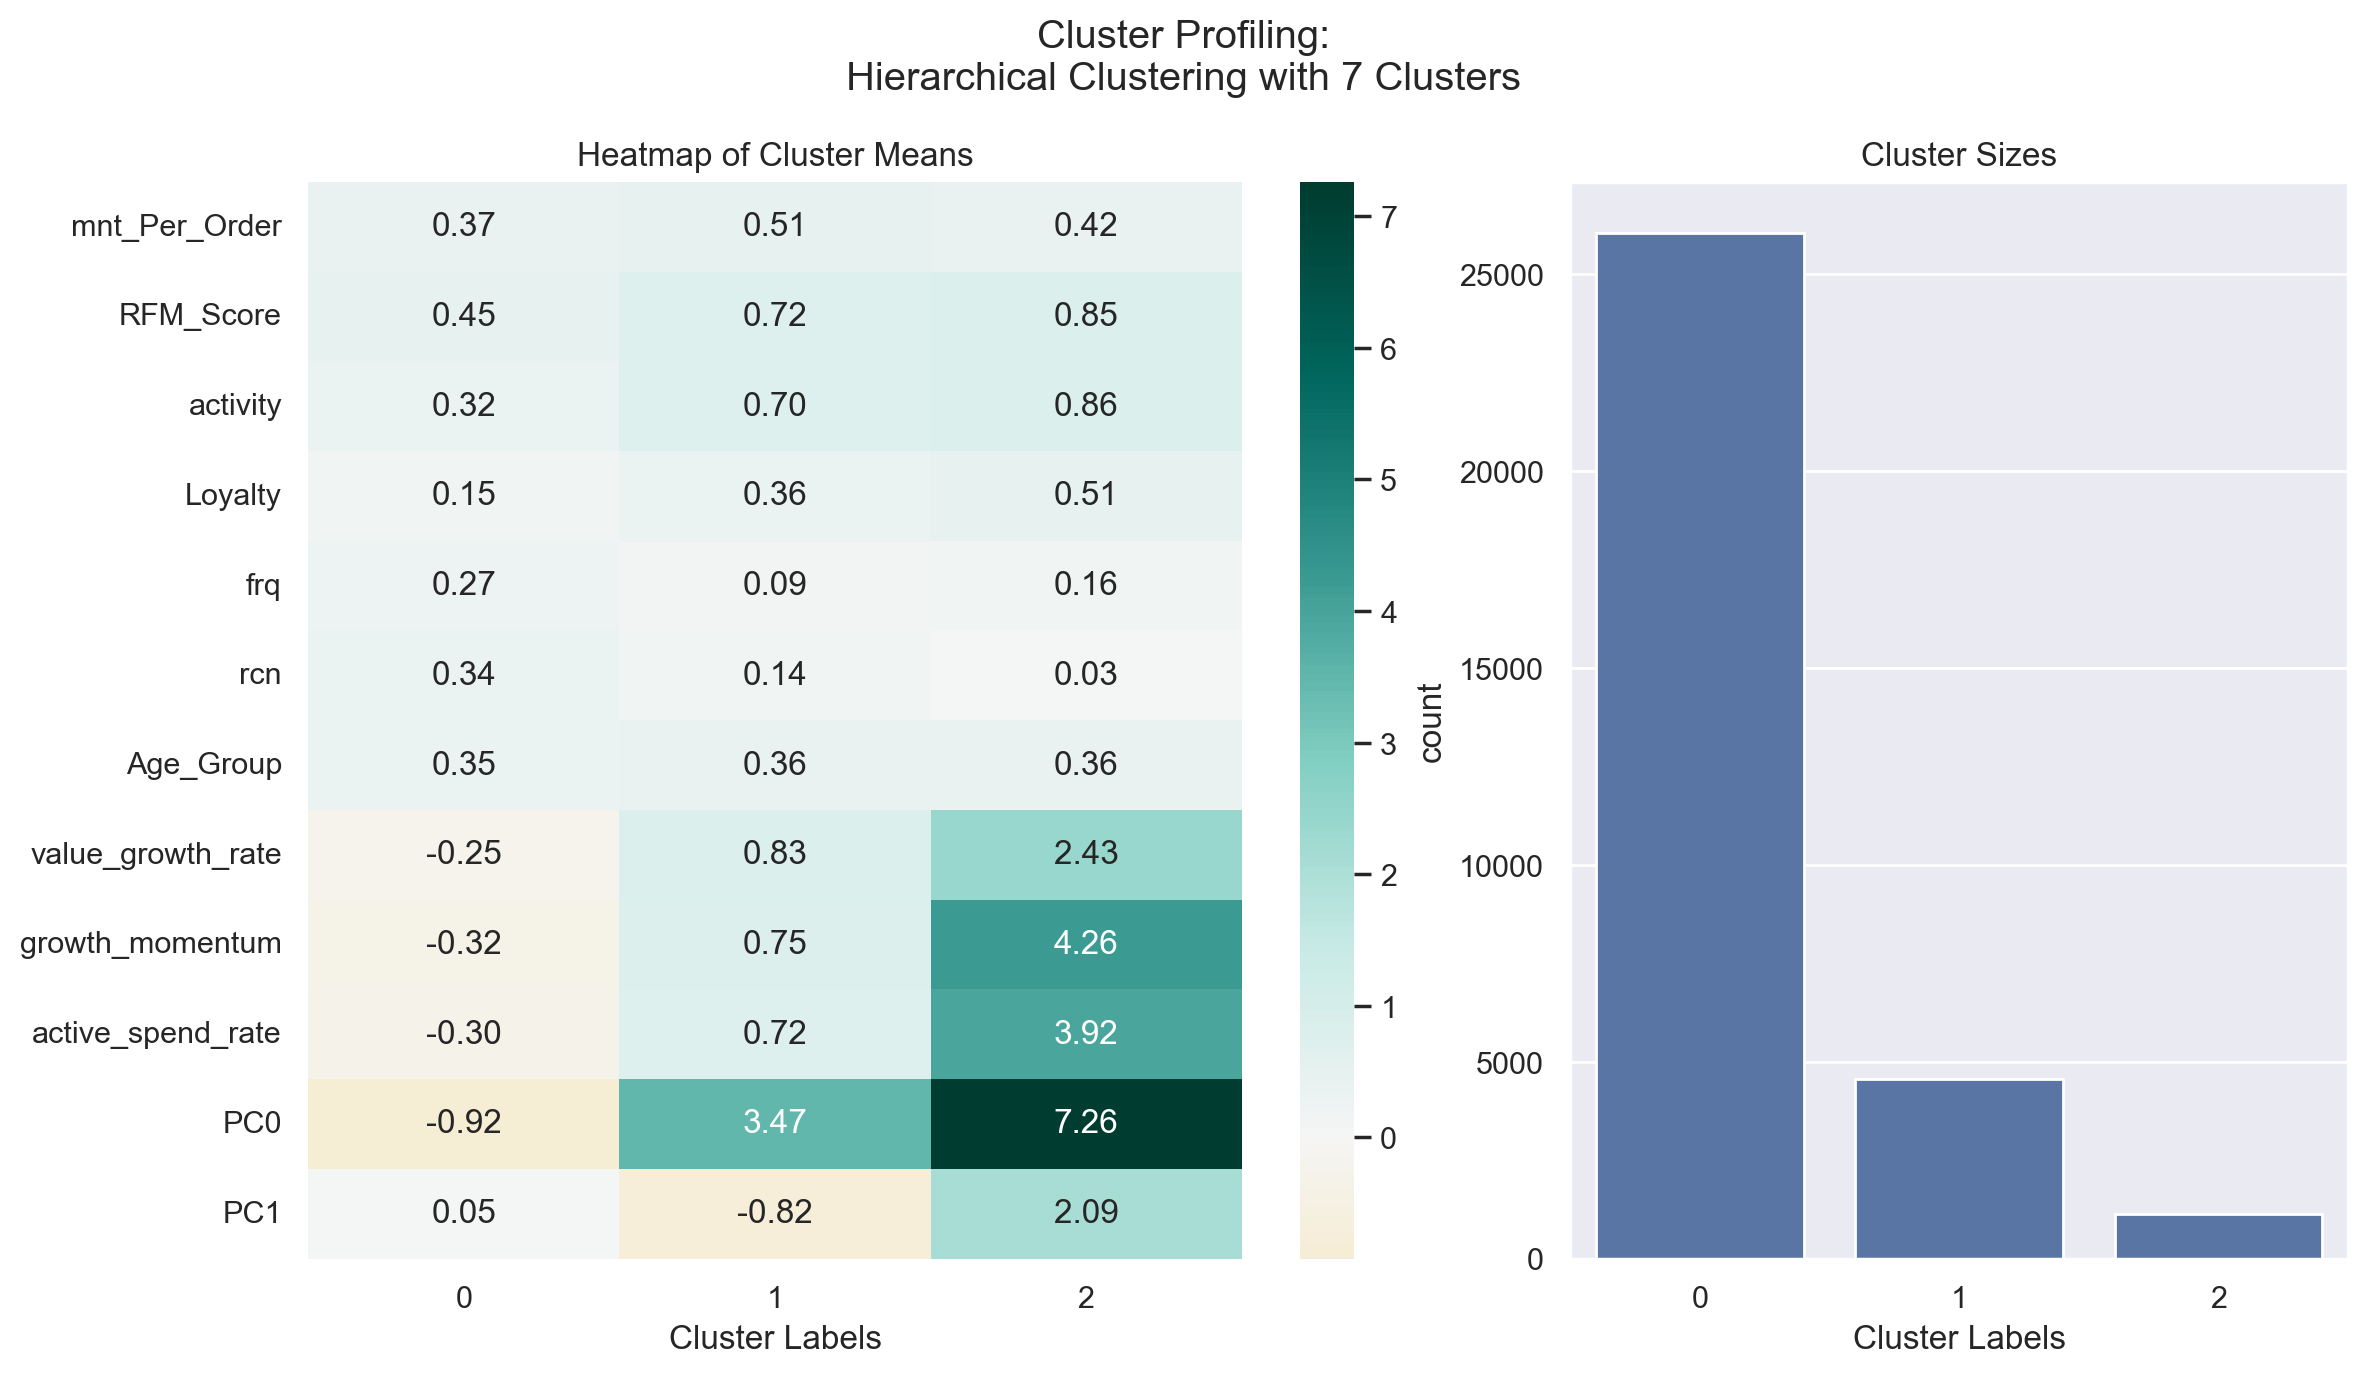

In [31]:
label_counts = None 

fig, axes = plt.subplots(1,2, figsize=(12,7), width_ratios=[.6,.4], tight_layout=True)

hc_profile = df_concat.groupby('labels').mean().T

sns.heatmap(hc_profile,
            center=0, annot=True, cmap="BrBG", fmt=".2f",
            ax=axes[0]
            )
axes[0].set_xlabel("Cluster Labels")
axes[0].set_title("Heatmap of Cluster Means")


sns.countplot(df_concat, x='labels', ax=axes[1])
axes[1].set_title("Cluster Sizes")
axes[1].set_xlabel("Cluster Labels")

fig.suptitle("Cluster Profiling:\nHierarchical Clustering with 7 Clusters")
plt.show()

#### Hierchical Clsutering With MiniSOM

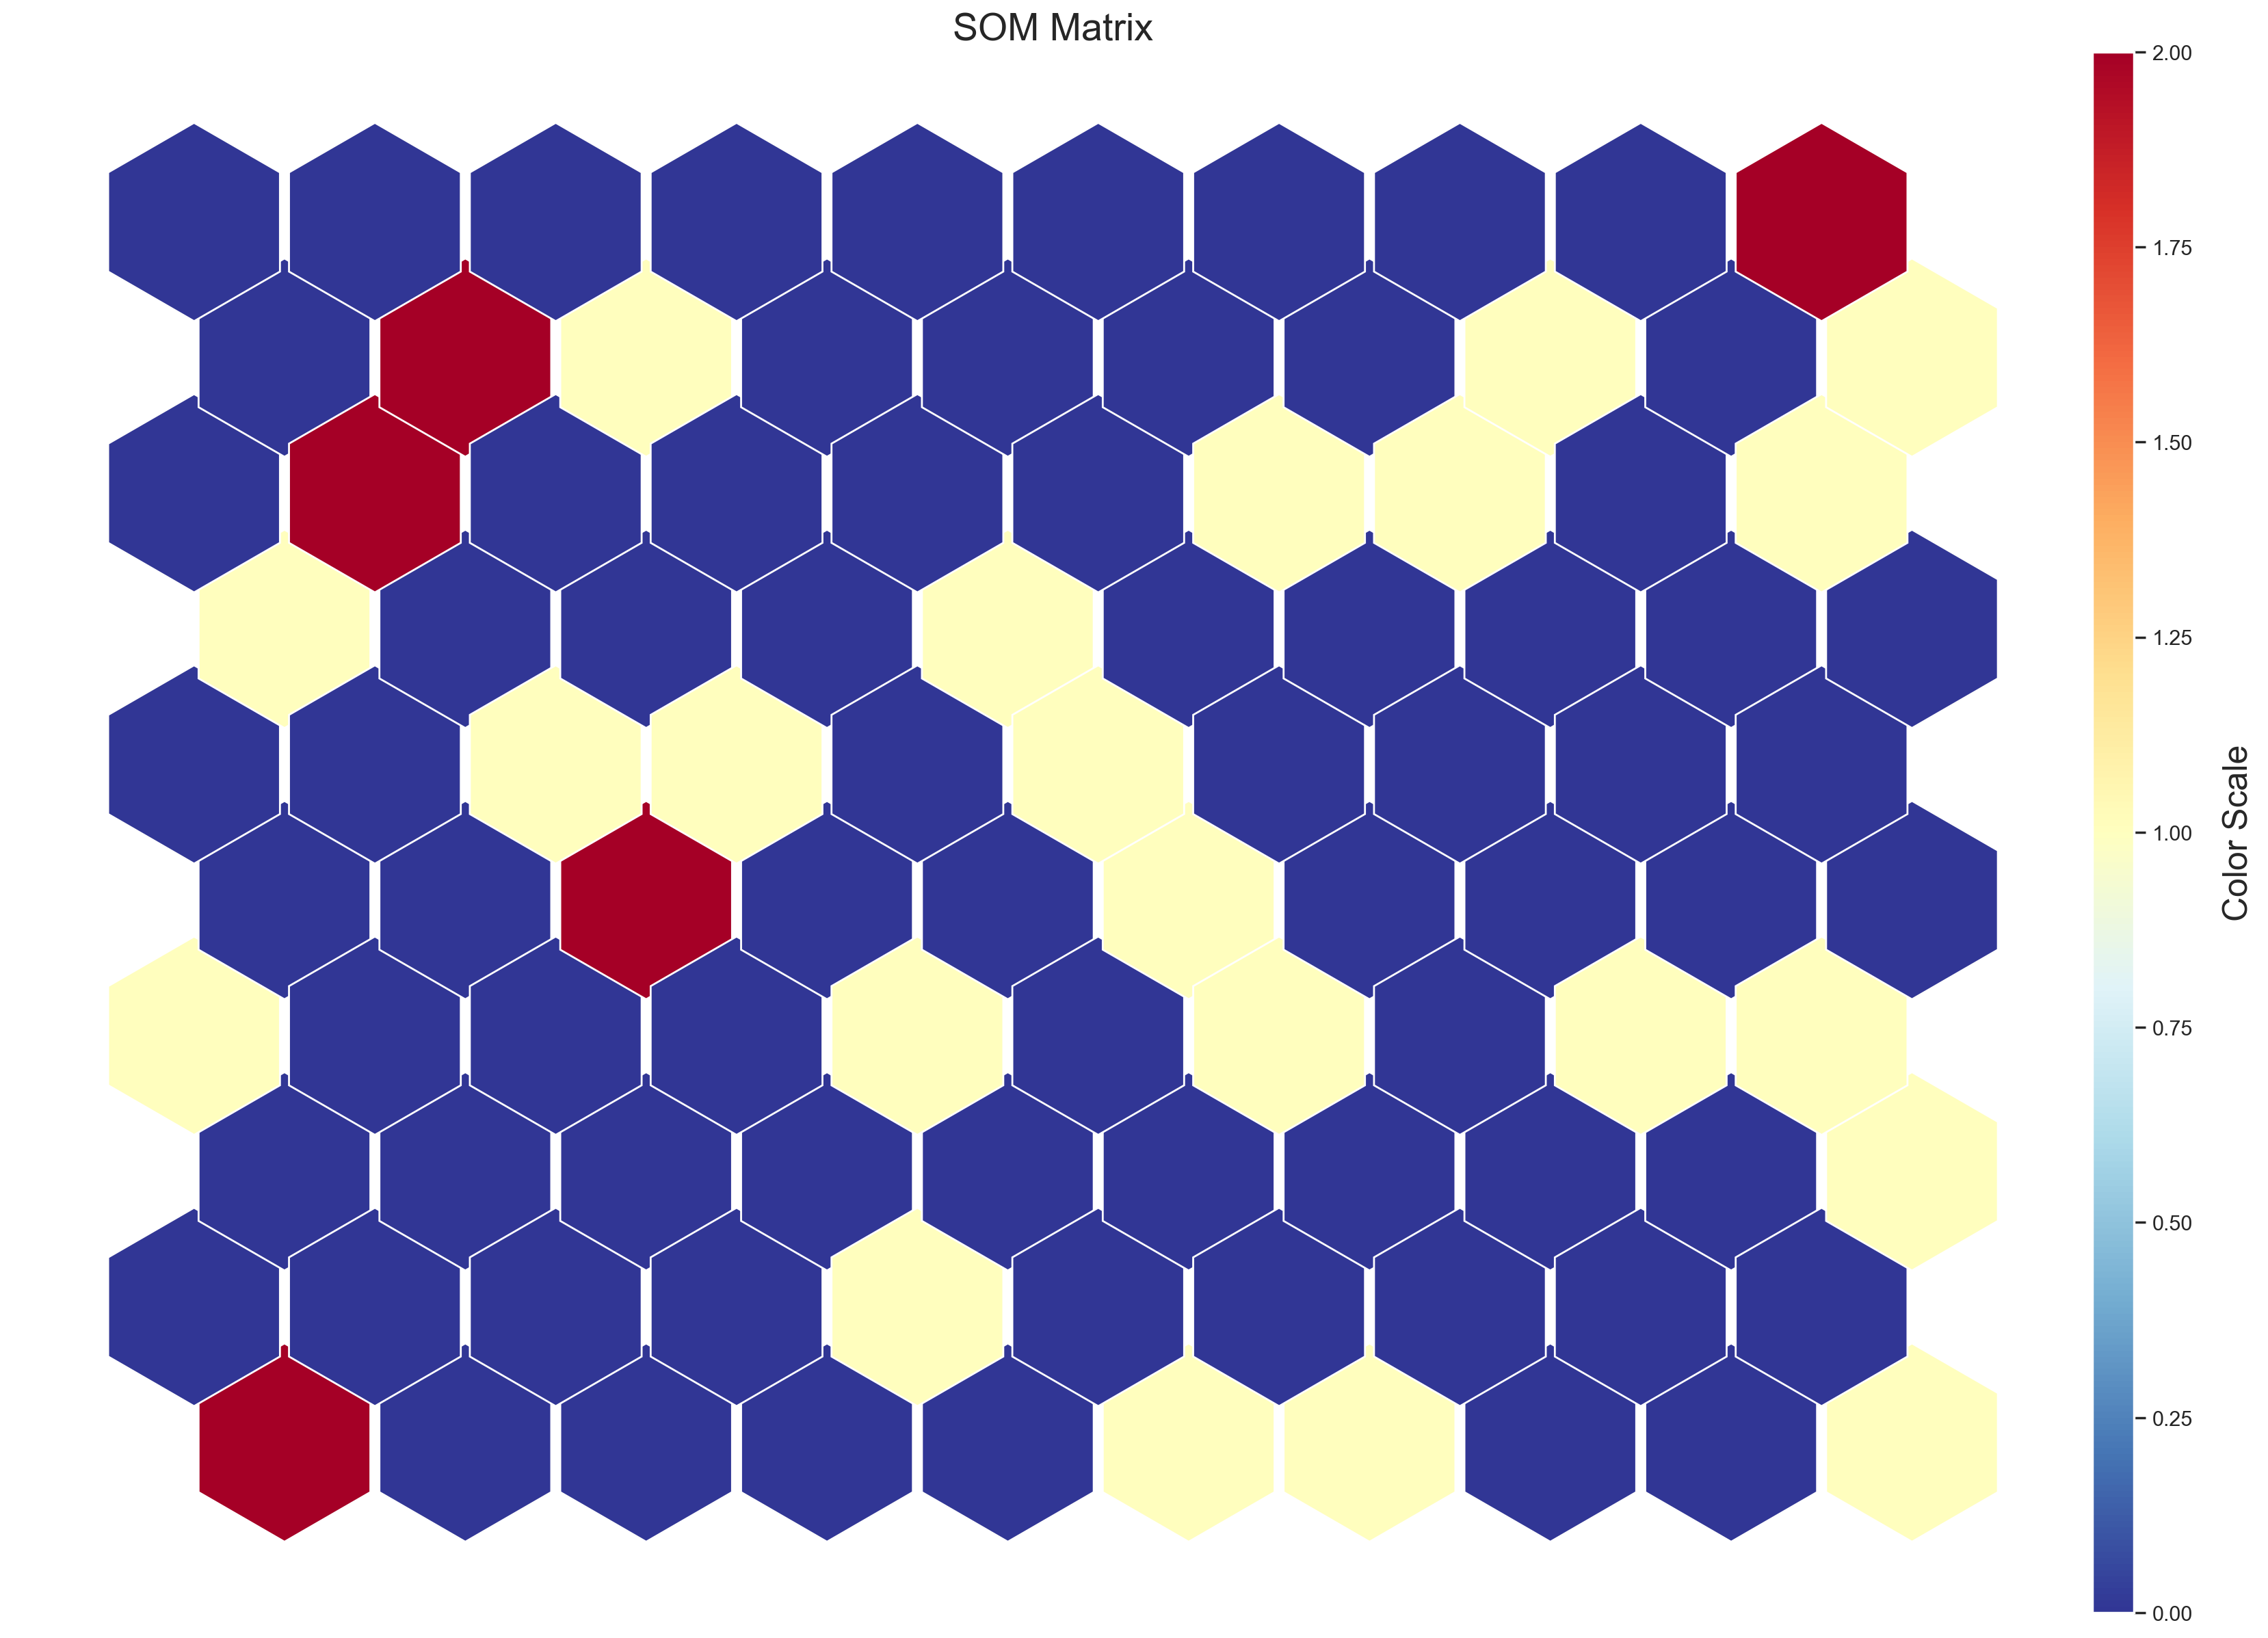

In [32]:
hierclust = AgglomerativeClustering(n_clusters=3, linkage='ward')
nodeclus_labels = hierclust.fit_predict(weights)
hclust_matrix = nodeclus_labels.reshape((M,N))

plot_som_hexagons(sm, hclust_matrix, cmap=cm.RdYlBu_r, annotate=False)
plt.show()

### KMeans Clustering

In [33]:
# Initialization method providing n_init
kmclust = KMeans(n_clusters=5, init='k-means++', n_init=50, random_state=1)
kmclust.fit(df_value)
# predicting
kmclust.predict(df_value)

array([0, 0, 0, ..., 0, 0, 0])

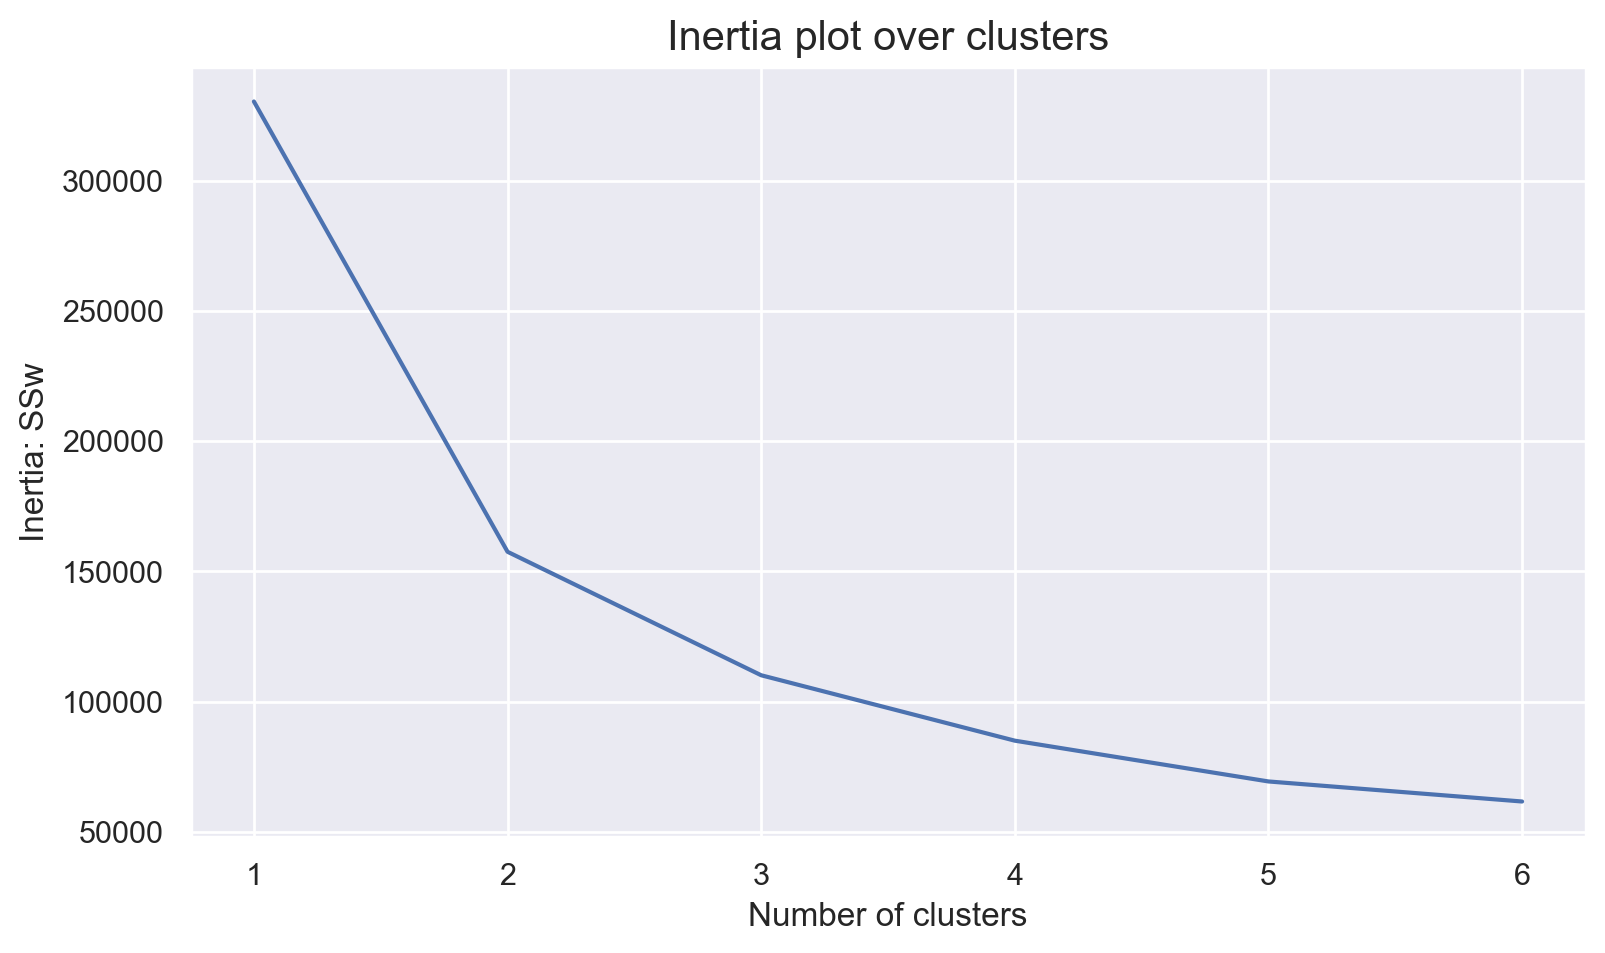

In [34]:
range_clusters = range(1, 7)

inertia = []
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(df_value)
    inertia.append(kmclust.inertia_)  # save the inertia of the given cluster solution

# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(range_clusters, inertia)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

For n_clusters = 2, the average silhouette_score is : 0.5910577603395425
For n_clusters = 3, the average silhouette_score is : 0.47264317206426976
For n_clusters = 4, the average silhouette_score is : 0.3807500230528564
For n_clusters = 5, the average silhouette_score is : 0.37009625668952406
For n_clusters = 6, the average silhouette_score is : 0.35212878715620566


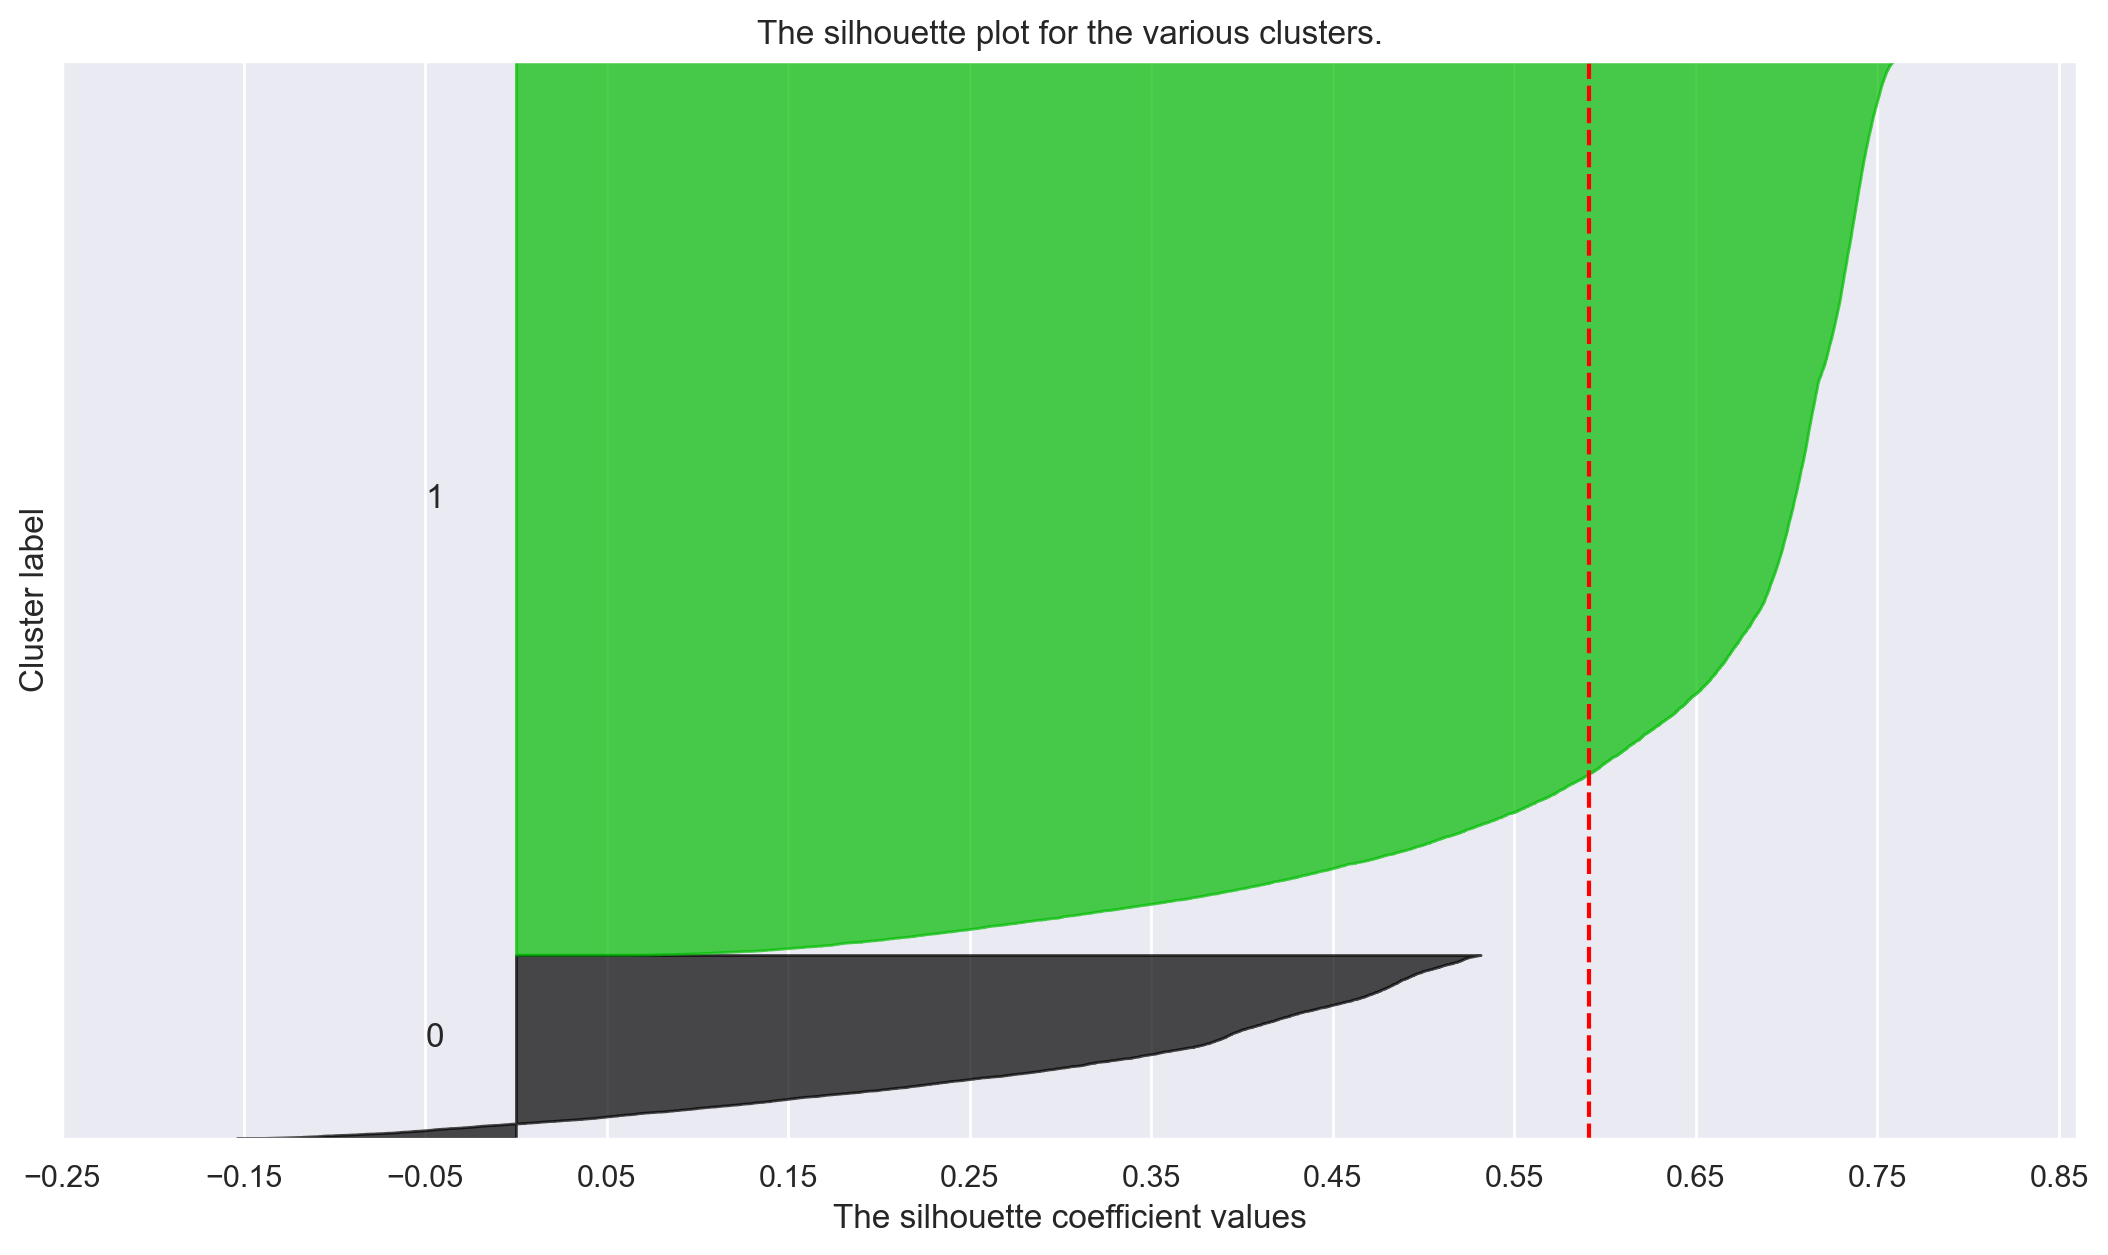

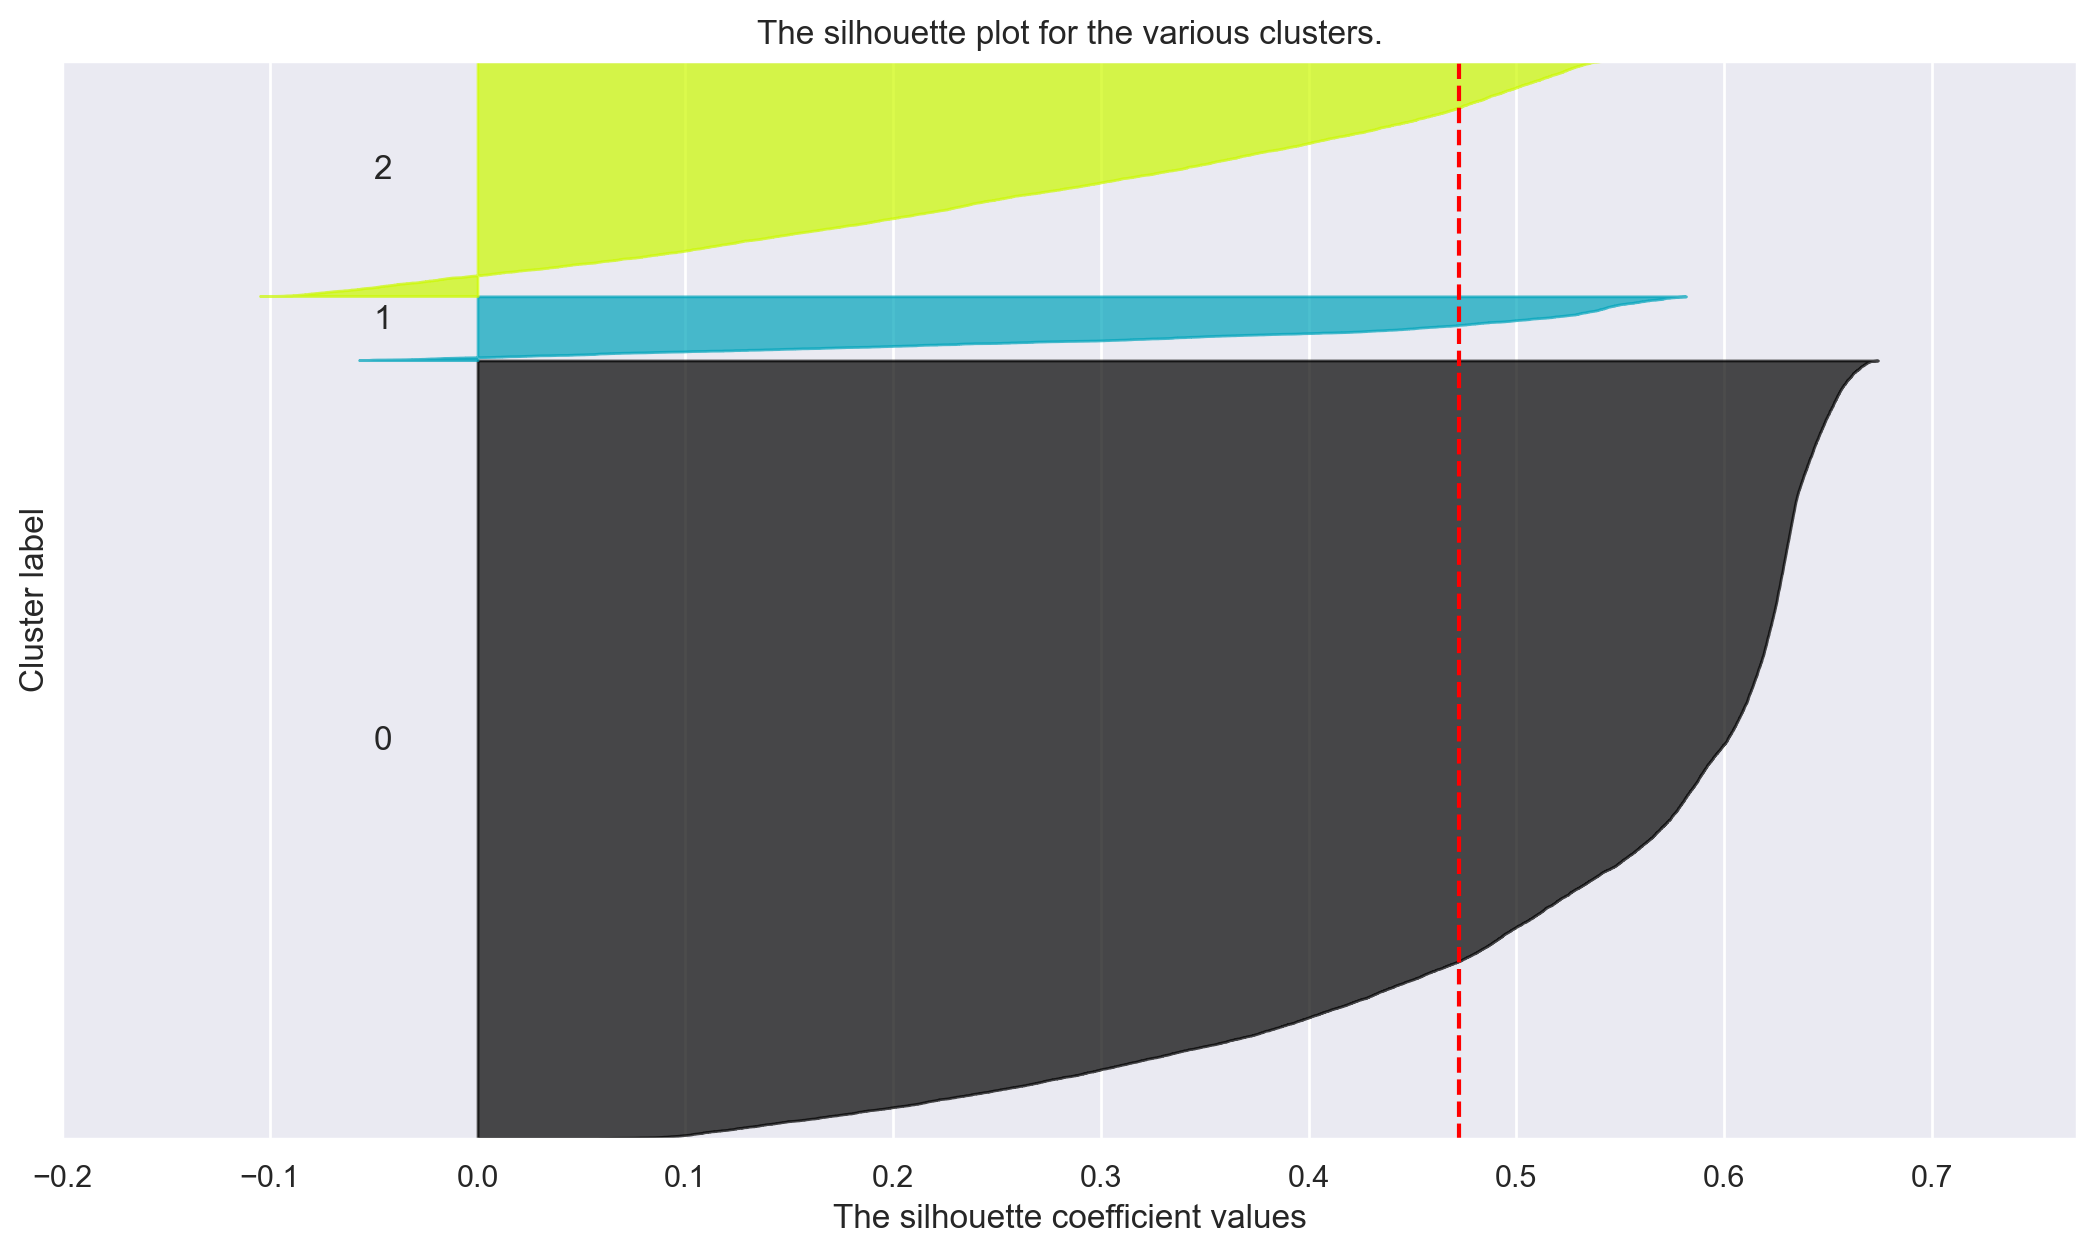

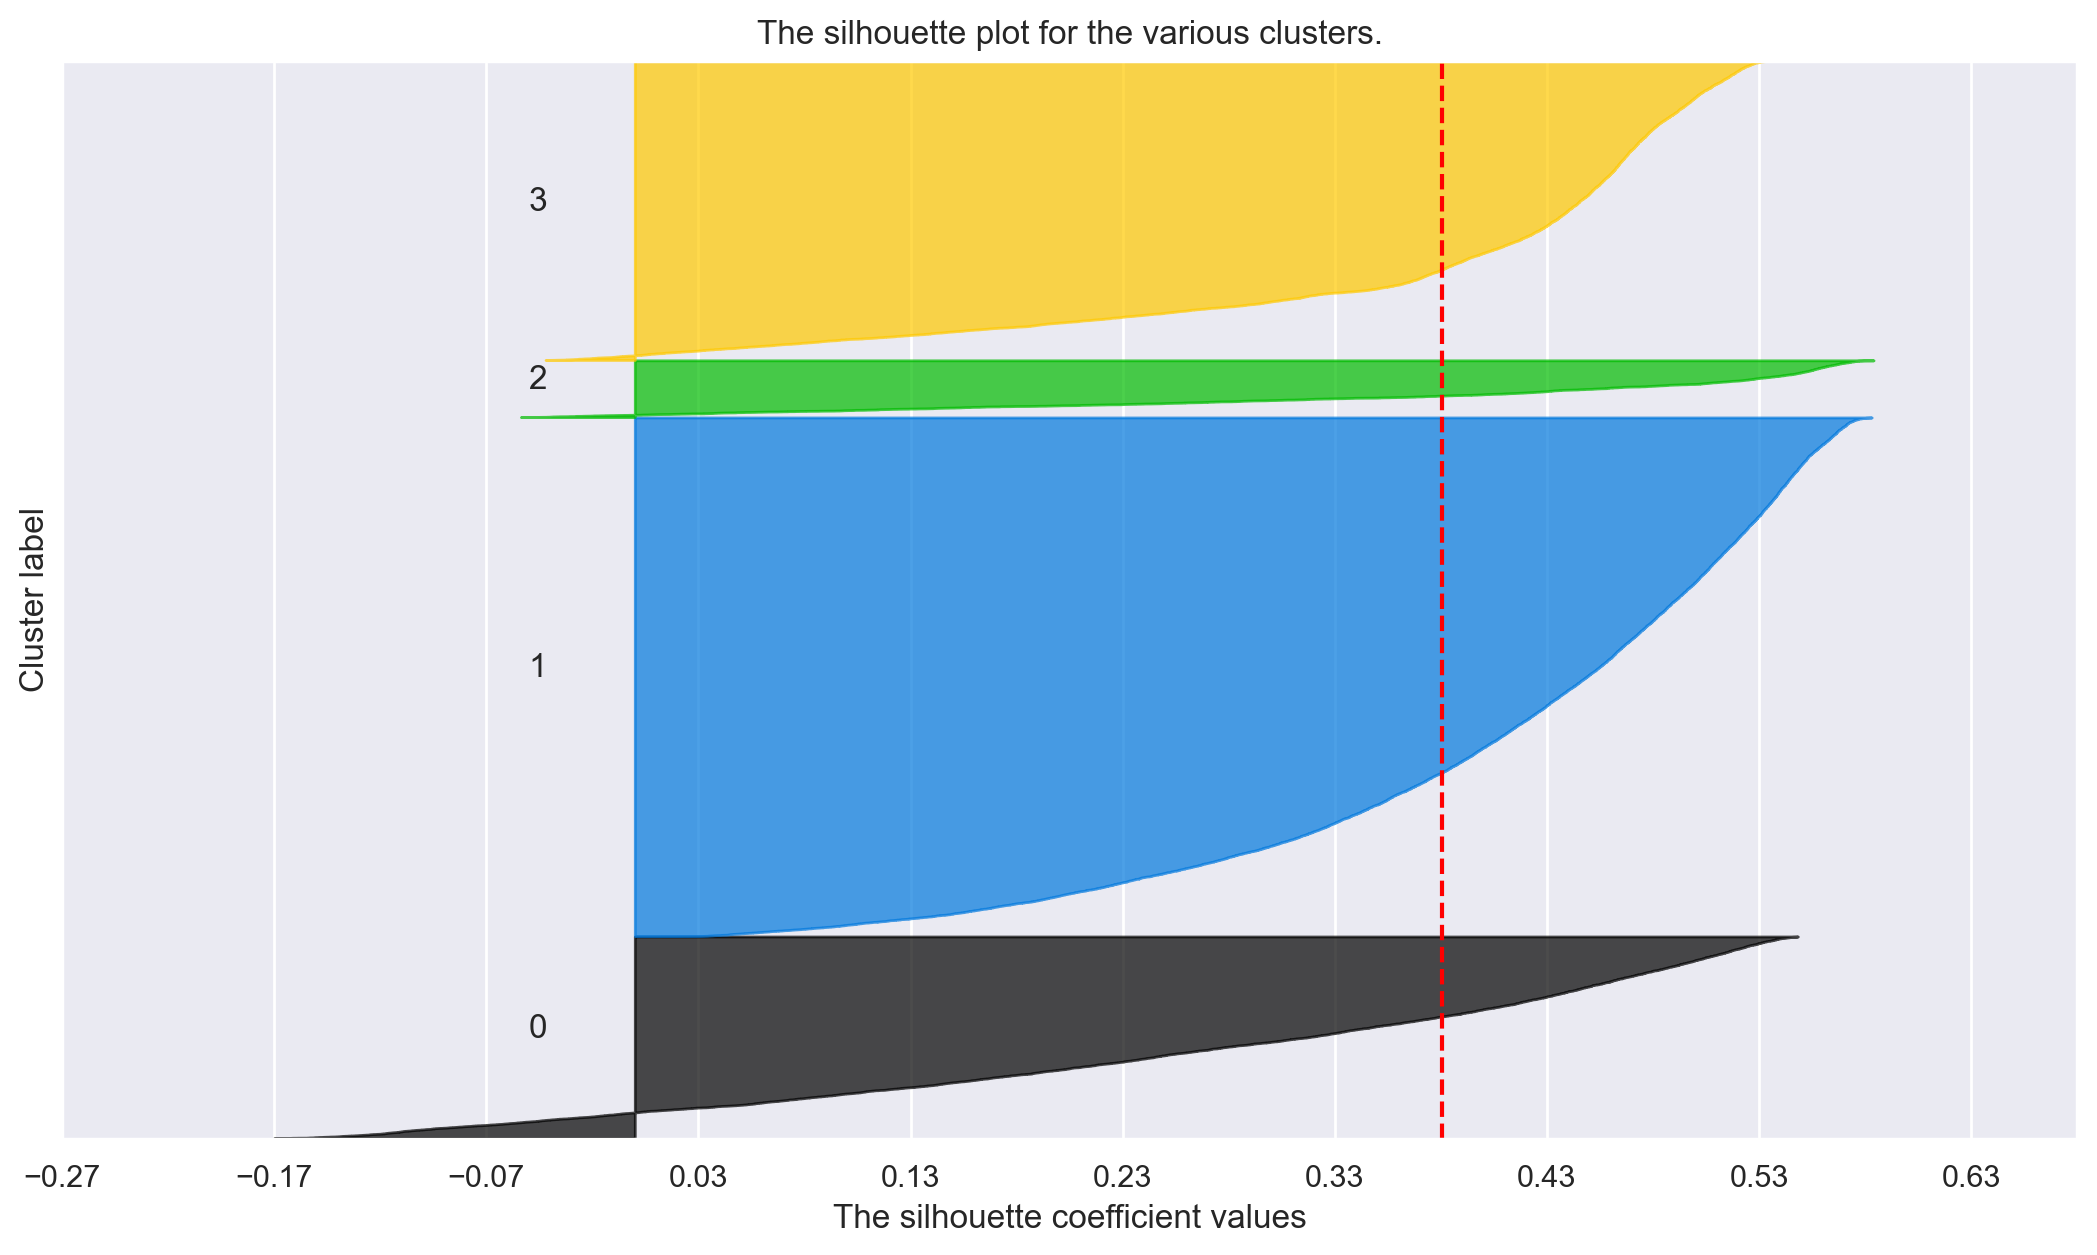

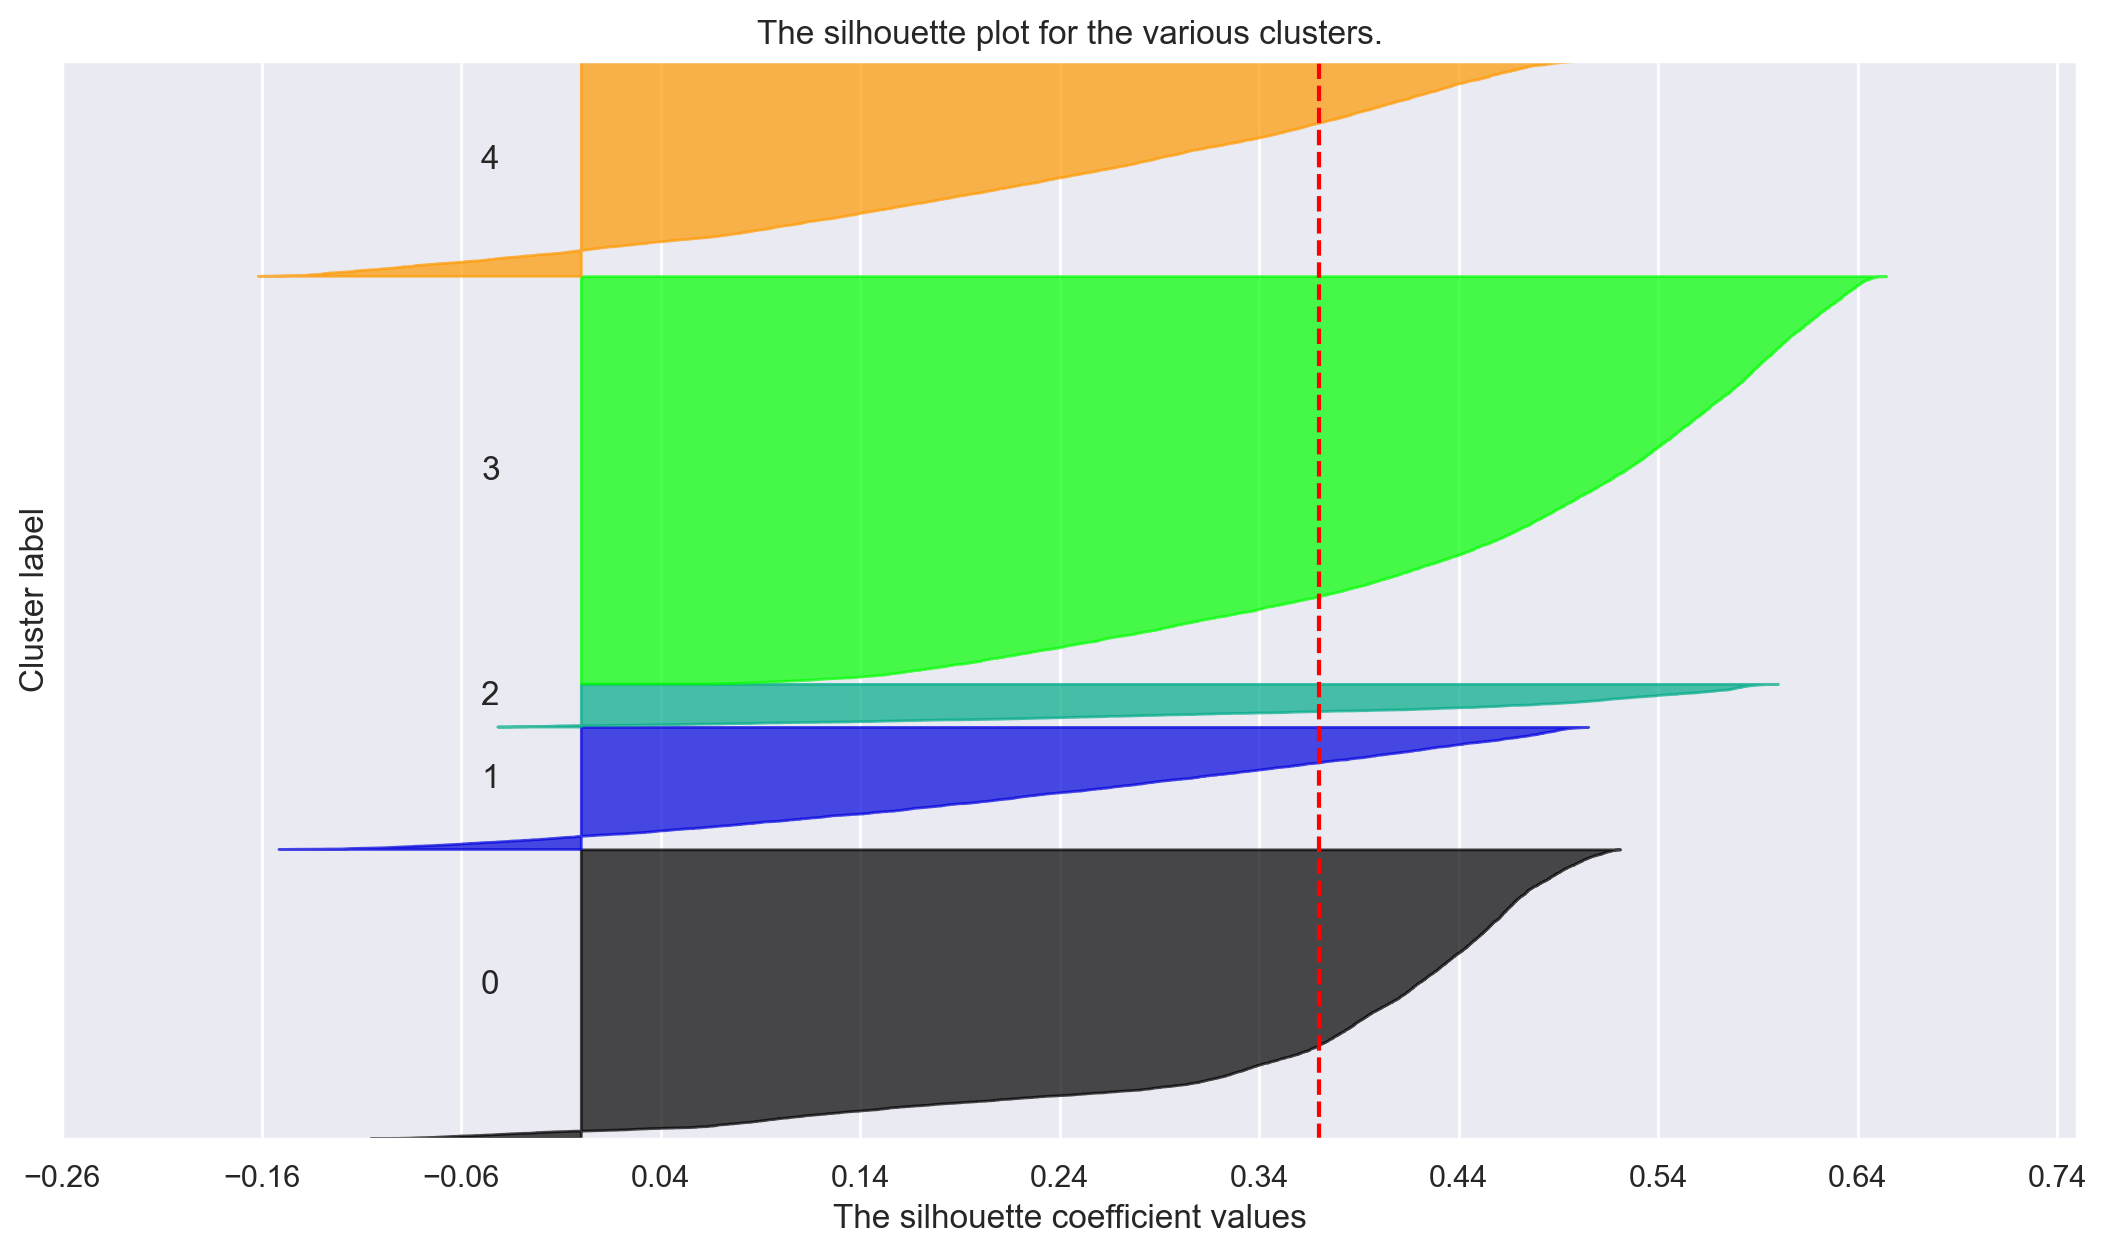

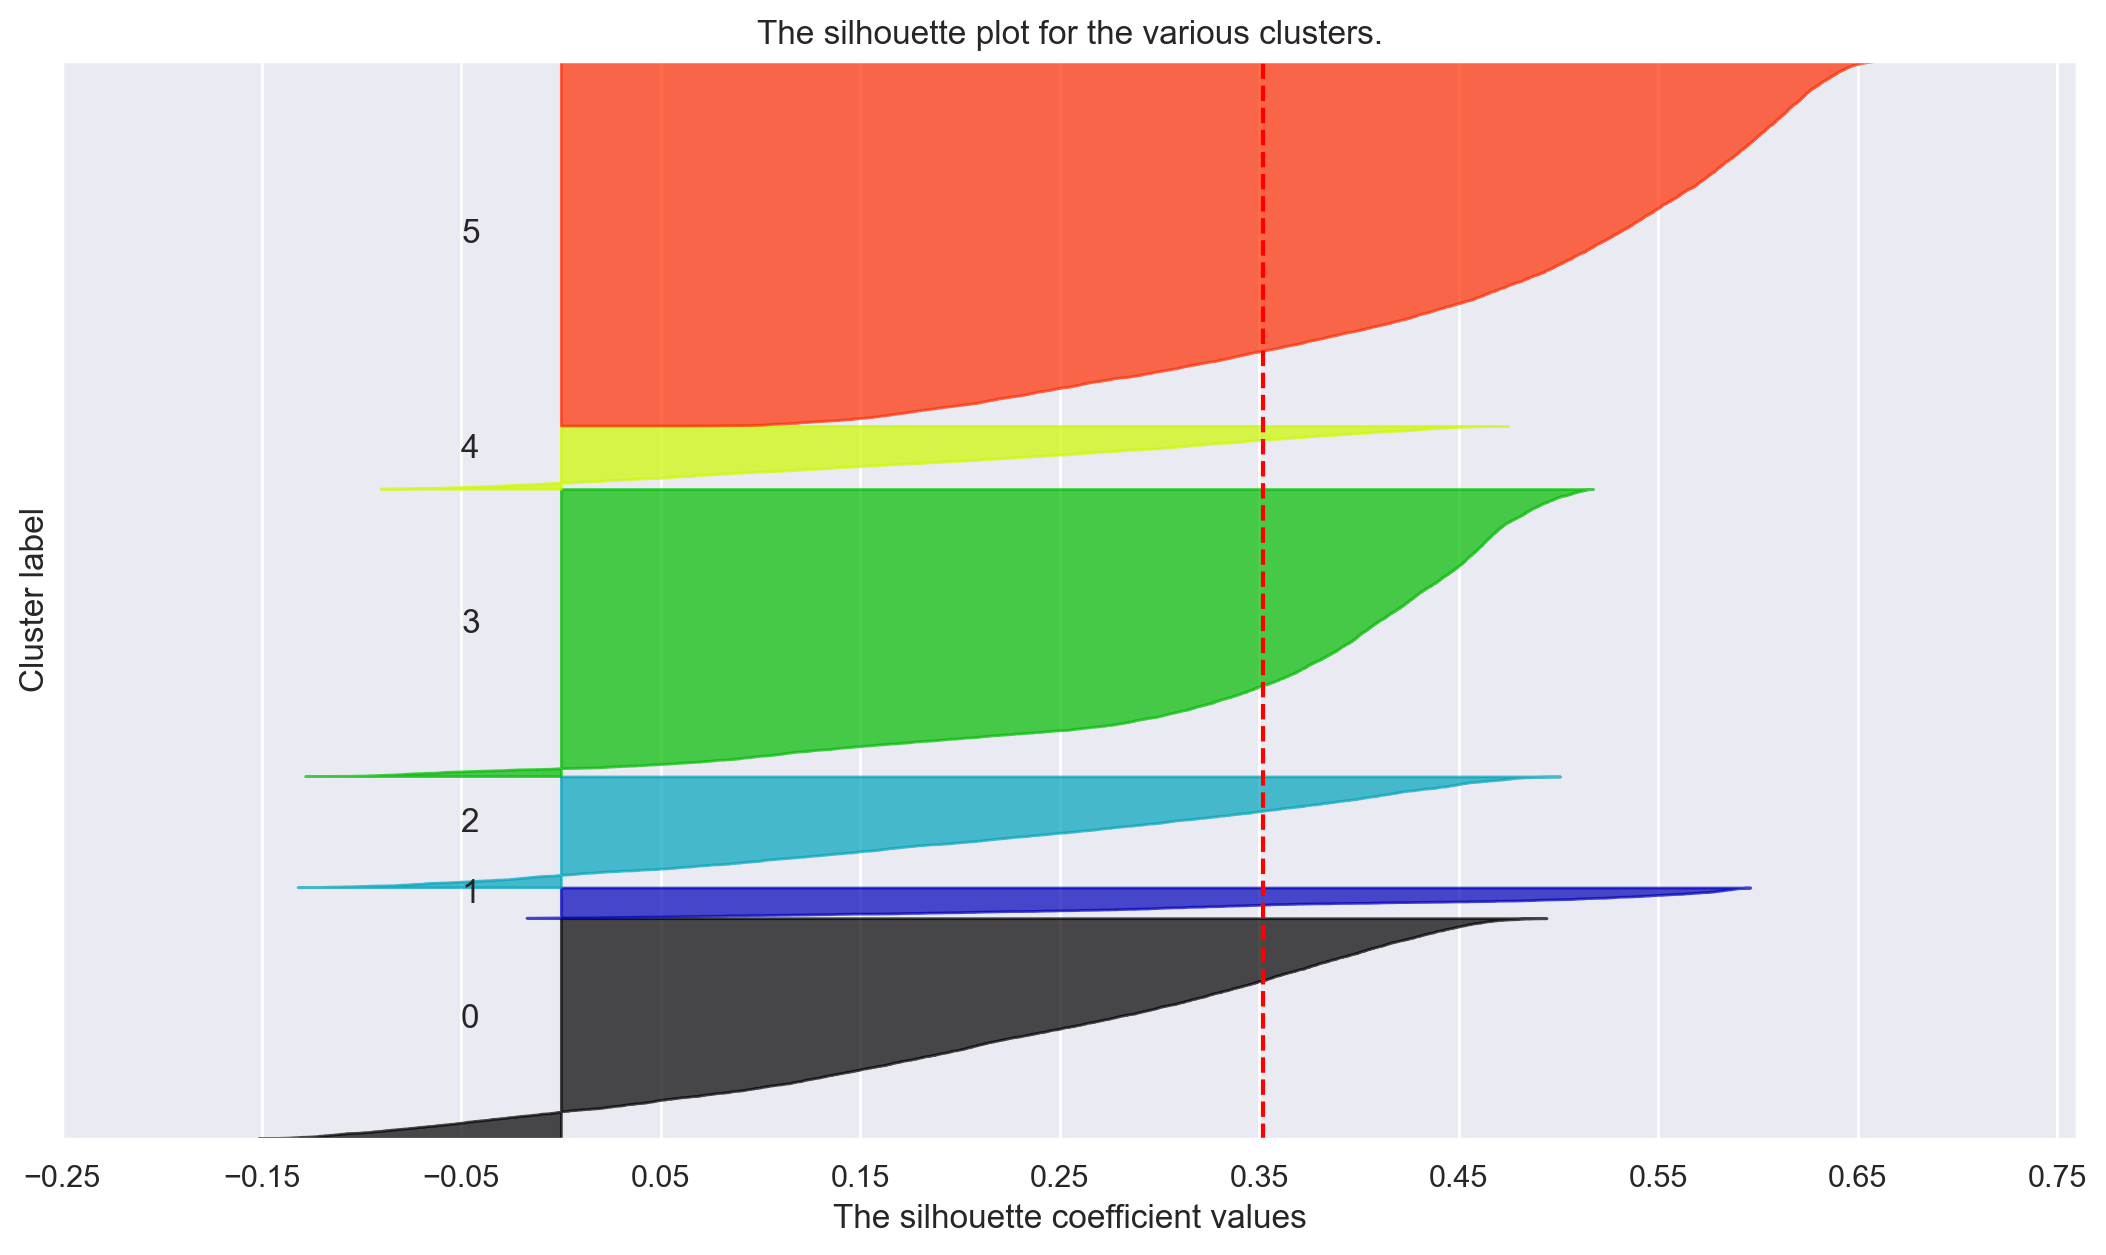

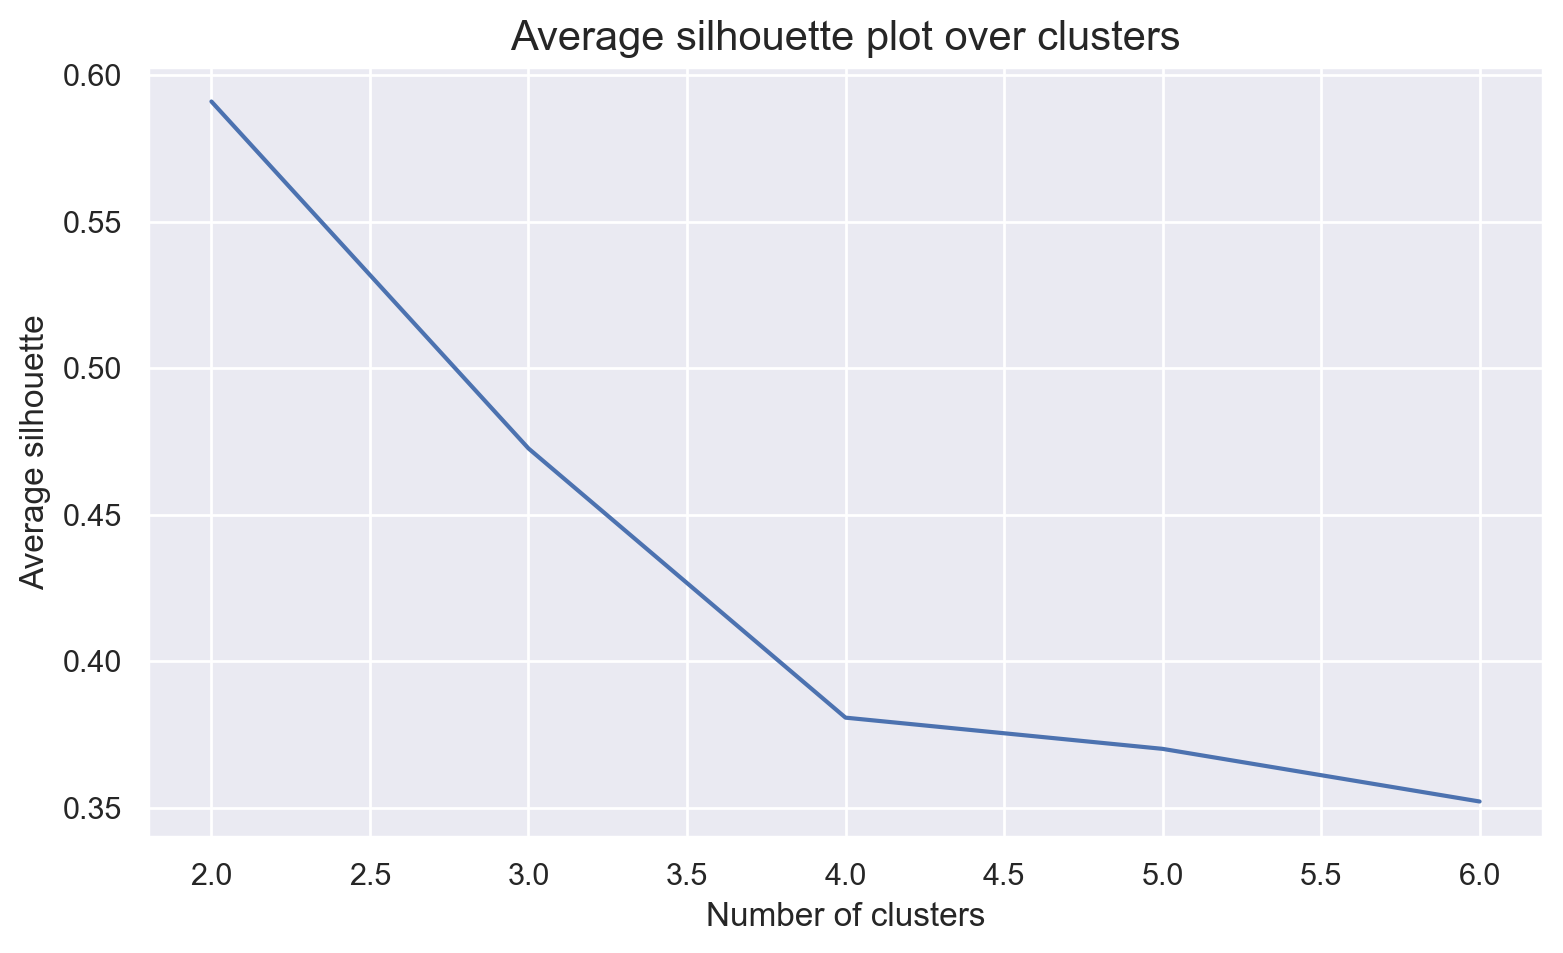

In [35]:
# Storing average silhouette metric
avg_silhouette = []
for nclus in range_clusters:
    # Skip nclus == 1
    if nclus == 1:
        continue
    
    # Create a figure
    fig = plt.figure(figsize=(13, 7))

    # Initialize the KMeans object with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=50, random_state=1)
    cluster_labels = kmclust.fit_predict(df_value)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(df_value, cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_value, cluster_labels)

    y_lower = 10
    for i in range(nclus):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        # Get y_upper to demarcate silhouette y range size
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # Filling the silhouette
        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    # The silhouette coefficient can range from -1, 1
    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])
    
    # The (nclus+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(df_value) + (nclus + 1) * 10])

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks(np.arange(xmin, xmax, 0.1))

# The average silhouette plot
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(range_clusters[1:], ## Plot X-axis; Why range_clusters[1:] ? Remember we skipped k=1 in the cell above
         avg_silhouette)     ## Plot Y-axis

plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()

In [36]:
# final cluster solution
number_clusters = 3
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=15, random_state=1)
km_labels = kmclust.fit_predict(df_value)
km_labels

# Characterizing the final clusters
df_concat = pd.concat((df_value, pd.Series(km_labels, name='labels', index=df.index)), axis=1)
df_concat.groupby('labels').mean()

mnt_Per_Order  RFM_Score  activity   Loyalty       frq       rcn  \
labels                                                                     
0            0.345587   0.422728  0.296159  0.135925  0.282418  0.357642   
1            0.424408   0.844016  0.839468  0.482776  0.143850  0.037069   
2            0.525203   0.675120  0.596280  0.307183  0.121368  0.177678   

        Age_Group  value_growth_rate  growth_momentum  active_spend_rate  \
labels                                                                     
0        0.353867          -0.347344        -0.358527          -0.359698   
1        0.356383           2.104630         3.380335           3.160647   
2        0.355395           0.577922         0.268929           0.332379   

             PC0       PC1  
labels                      
0      -1.223491  0.112467  
1       6.423771  1.462133  
2       2.304074 -0.768482

### Density Clustering

In [37]:
bandwidth = estimate_bandwidth(df_value, quantile=0.06, random_state=1, n_jobs=-1)
bandwidth

1.3641859520572346

In [38]:
# Perform mean-shift clustering with bandwidth set using estimate_bandwidth
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs=4)
ms_labels = ms.fit_predict(df_value)

ms_n_clusters = len(np.unique(ms_labels))
print("Number of estimated clusters : %d" % ms_n_clusters)

Number of estimated clusters : 20


In [39]:
# Concatenating the labels to df
df_concat = pd.concat([df_value, pd.Series(ms_labels, index=df.index, name="ms_labels")], axis=1)
df_concat.head()

mnt_Per_Order  RFM_Score  activity  Loyalty       frq       rcn  Age_Group  \
0       0.578417       0.55  0.011111      0.0  0.717691  1.000000        0.2   
1       0.379445       0.45  0.011111      0.0  0.717691  1.000000        0.0   
2       0.173895       0.35  0.011111      0.6  0.717691  1.000000        0.6   
3       0.633505       0.55  0.022222      0.0  0.473024  0.988889        0.4   
4       1.000000       0.65  0.022222      0.0  0.473024  0.988889        0.2   

   value_growth_rate  growth_momentum  active_spend_rate       PC0       PC1  \
0           0.572915        -0.400294          -0.482013 -0.579423  0.875097   
1           0.090905        -0.402728          -0.482338 -1.227516  1.000403   
2          -0.408052        -0.404200          -0.482676 -1.893921  1.125455   
3           0.457031        -0.398483          -0.480858 -0.518338  0.193247   
4           1.456348        -0.385500          -0.479249  0.981452 -0.143016   

   ms_labels  
0          1  
1          1  
2          1  
3          1  
4          0

In [40]:
# Computing the R^2 of the cluster solution
sst = get_ss(df_value, value_columns)  # get total sum of squares
ssw_labels = df_concat.groupby(by='ms_labels').apply(lambda group: get_ss(group, df_concat.columns))
 # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

Cluster solution with R^2 of 0.7350


### DBSCAN

In [41]:
# Perform DBSCAN clustering
dbscan = DBSCAN(eps=1.9, min_samples=20, n_jobs=4)
dbscan_labels = dbscan.fit_predict(df_value)

dbscan_n_clusters = len(np.unique(dbscan_labels))
print("Number of estimated clusters : %d" % dbscan_n_clusters)

Number of estimated clusters : 2


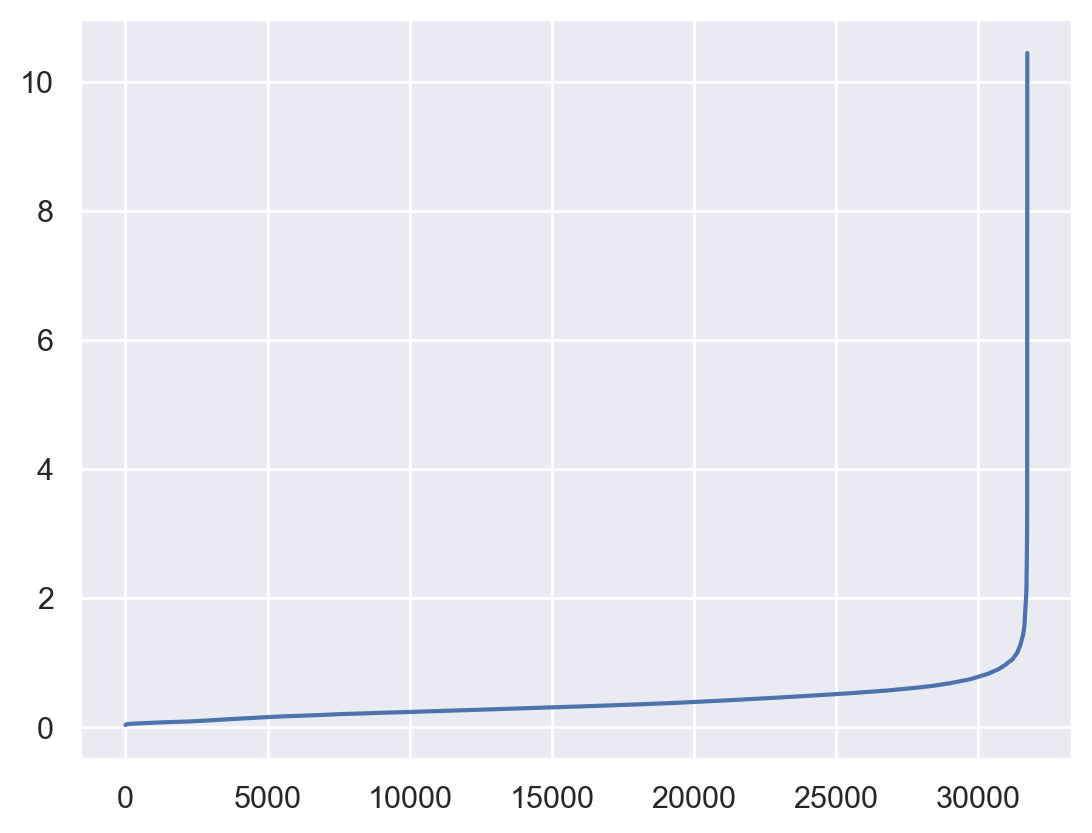

In [42]:
# K-distance graph to find out the right eps value
neigh = NearestNeighbors(n_neighbors=20)
neigh.fit(df_value)
distances, _ = neigh.kneighbors(df_value)
distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.show()

In [43]:
# Concatenating the labels to df
df_concat = pd.concat([df_value, pd.Series(dbscan_labels, index=df.index, name="dbscan_labels")], axis=1)
# Detecting noise (potential outliers)
df_concat.loc[df_concat['dbscan_labels'] <0]

mnt_Per_Order  RFM_Score  activity   Loyalty       frq       rcn  \
1268        0.253649   1.000000  0.977778  0.960000  0.725939  0.033333   
1270        0.605139   1.000000  0.977778  0.689362  0.758927  0.033333   
1434        0.246249   0.883333  1.000000  0.466667  0.128876  0.011111   
3375        0.196095   0.883333  0.977778  0.257143  0.214611  0.011111   
4308        0.198972   0.883333  0.966667  0.432000  0.192212  0.011111   
9270        0.191572   0.666667  0.900000  0.150000  0.055299  0.011111   
10927       0.242549   0.766667  0.866667  0.000000  0.067309  0.011111   
12129       0.133196   0.883333  0.844444  0.646154  0.107611  0.011111   
28139       0.389723   1.000000  0.277778  0.720000  0.548306  0.022222   
29853       0.204728   1.000000  0.144444  0.240000  0.770120  0.033333   
30216       0.483453   1.000000  0.133333  0.500000  0.661230  0.022222   
30406       0.799589   0.883333  0.088889  0.960000  0.391468  0.044444   
30985       1.000000   0.883333  0.066667  0.000000  0.298261  0.022222   
31704       1.000000   1.000000  0.000000  0.000000  1.000000  0.000000   

       Age_Group  value_growth_rate  growth_momentum  active_spend_rate  \
1268         0.6           8.165103         2.254855           3.593422   
1270         0.2           8.302871         2.204977           3.593422   
1434         0.4           2.279884        12.061666          11.811707   
3375         0.4           3.814668        11.181718          11.613521   
4308         0.4           3.447485        11.399396          11.513592   
9270         0.4          -0.211267         2.046158           5.304685   
10927        0.2           0.222551         4.377901           6.966701   
12129        0.4           0.498549         2.784775           5.775280   
28139        0.4           7.287204         4.090595           1.702898   
29853        0.6           7.041718         1.504474           0.215412   
30216        0.4           7.955192         3.785029           0.633165   
30406        0.2           5.847059         2.043115          -0.099150   
30985        0.2           4.944963         4.956371           0.092547   
31704        0.4           9.359660         7.500525          -0.482974   

             PC0       PC1  dbscan_labels  
1268    7.518469  4.222150             -1  
1270    7.509327  4.279111             -1  
1434   12.952244  6.326437             -1  
3375   12.846933  6.621892             -1  
4308   12.839082  6.506528             -1  
9270    3.492121  3.236788             -1  
10927   5.992284  3.829116             -1  
12129   4.529234  3.576005             -1  
28139   8.011613  3.476819             -1  
29853   5.719820  2.920821             -1  
30216   7.797368  3.309111             -1  
30406   6.531847  1.119262             -1  
30985   7.686538  1.980253             -1  
31704   9.124372  4.411083             -1

In [44]:
# Computing the R^2 of the cluster solution
df_nonoise = df_concat.loc[df_concat['dbscan_labels'] != -1]
sst = get_ss(df_value, value_columns)  # get total sum of squares
ssw_labels = df_nonoise.groupby(by='dbscan_labels').apply(lambda group: get_ss(group, df_nonoise.columns))
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

Cluster solution with R^2 of 0.0087


### GMM (Gaussian Mixture Model )

In [45]:
'''# Selecting number of components based on AIC and BIC
n_components = np.arange(1, 16)
models = [GaussianMixture(n, covariance_type='full', n_init=10, random_state=1).fit(df_value)
          for n in n_components]

bic_values = [m.bic(df_value) for m in models]
aic_values = [m.aic(df_value) for m in models]
plt.plot(n_components, bic_values, label='BIC')
plt.plot(n_components, aic_values, label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.xticks(n_components)
plt.show()'''

"# Selecting number of components based on AIC and BIC\nn_components = np.arange(1, 16)\nmodels = [GaussianMixture(n, covariance_type='full', n_init=10, random_state=1).fit(df_value)\n          for n in n_components]\n\nbic_values = [m.bic(df_value) for m in models]\naic_values = [m.aic(df_value) for m in models]\nplt.plot(n_components, bic_values, label='BIC')\nplt.plot(n_components, aic_values, label='AIC')\nplt.legend(loc='best')\nplt.xlabel('n_components')\nplt.xticks(n_components)\nplt.show()"

In [46]:
# Performing GMM clustering
gmm = GaussianMixture(n_components=4, covariance_type='full', n_init=10, init_params='kmeans', random_state=1)
gmm_labels = gmm.fit_predict(df_value)
labels_proba = gmm.predict_proba(df_value)

In [47]:
# Concatenating the labels to df
df_concat = pd.concat([df[metric_features], pd.Series(gmm_labels, index=df.index, name="gmm_labels")], axis=1)
df_concat.head()

RFM_Score  DOW_2  CUI_Cafe  Unnamed: 0  activity  vendor_count  is_chain  \
0       0.55    0.0       0.0           0  0.011111      0.142857  0.166667   
1       0.45    0.0       0.0           1  0.011111      0.142857  0.333333   
2       0.35    0.0       0.0           2  0.011111      0.000000  0.333333   
3       0.55    0.0       0.0           3  0.022222      0.142857  0.166667   
4       0.65    0.0       0.0           4  0.022222      0.142857  0.000000   

   product_count  CUI_American  Orders_Morning  ...  CUI_Asian  \
0       0.307692      0.000000        0.000000  ...   0.000000   
1       0.076923      0.045751        0.034483  ...   0.007126   
2       0.076923      0.032833        0.034483  ...   0.000000   
3       0.153846      0.000000        0.017241  ...   0.015278   
4       0.307692      0.051997        0.034483  ...   0.045578   

   Total_Orders_Per_Client  Orders_Dusk   DOW_0  CUI_Chinese     DOW_1  \
0                    0.125          0.0  0.0625          0.0  0.000000   
1                    0.125          0.0  0.0625          0.0  0.000000   
2                    0.125          0.0  0.0625          0.0  0.000000   
3                    0.125          0.0  0.0000          0.0  0.058824   
4                    0.125          0.0  0.0000          0.0  0.058824   

   Orders_Night  CUI_Street_Food/Snacks       mnt  gmm_labels  
0           0.0                     0.0  0.306394           0  
1           0.0                     0.0  0.202472           0  
2           0.0                     0.0  0.094895           1  
3           0.0                     0.0  0.335196           1  
4           0.0                     0.0  0.591832           1  

[5 rows x 44 columns]

In [48]:
# Computing the R^2 of the cluster solution
sst = get_ss(df_value, value_columns)  # get total sum of squares
ssw_labels = df_concat.groupby(by='gmm_labels').apply(lambda group: get_ss(group, df_concat.columns))  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

Cluster solution with R^2 of -6812637.9706
